# **Exploring the Depths of the Voluntary Carbon Market: An In-Depth Analysis of VCM and Registry Fees - II**

In [55]:
import os
import re
import locale
import warnings
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gdp
import plotly.express as px
import matplotlib.pyplot as plt
from acr_fee_program import ACRFeeCalculator
from car_fee_program import CarCertificationFeesCalculator
from verra_fee_program import VCSCertificationFeesCalculator
from gold_standard_fee_program2 import GSCertificationFeesCalculator

# Set the global font to Times New Roman
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'

In [56]:
df=pd.read_csv('global.csv')

# **Certification costs computation**

The Berkley Carbon Trading Project has data on the four main registries on the world and for that purpose each free program from [Verified Carbon Standard](https://verra.org/wp-content/uploads/2023/03/Program-Fee-Schedule-v4.3-FINAL.pdf), [Gold Standard](https://globalgoals.goldstandard.org/standards/GS-fee-schedule-2023.pdf), [Climate Action Reserve](https://www.climateactionreserve.org/how/program-resources/program-fees/) and [American Carbon Registry](https://acrcarbon.org/wp-content/uploads/2023/09/ACR-Fee-Schedule.pdf) were meticulously examined and compiled into four individual Python scripts. These scripts were designed to unveil the true costs embedded within the certification process.

## **Verified Carbon Standard**

In [57]:
# Initialize an empty list to store dictionaries containing fee data
verra_fees_data = []
# Initialize the VERRA fee calculator
calculator = VCSCertificationFeesCalculator()


# Iterate through Verra projects in the DataFrame
for idx, project in df[df['Voluntary Registry'] == 'VCS'].iterrows():
    
    #  One-time fee
    account_opening_fee = calculator.calculate_account_opening_fee()
    
    #Fees to pay per project registry
    pipeline_listing_request_fee = calculator.calculate_pipeline_listing_request_fee()
    project_registration_request_review_fee = calculator.calculate_project_registration_request_review_fee()
    
    # Recurring fees
    #years_with_credits = [col for col in df.columns[df.columns.str.isnumeric()] if project[col] > 0]
    years_with_credits = [col for col in df.columns if col.startswith('registry_') and project[col] > 0]     #Change prefix to do other computations, vintage_, retired_, canceled_, registry_
    first_year = int(project['First Year of Project'])
    #last_year = int(years_with_credits[-1]) if years_with_credits else first_year
    last_year = int(years_with_credits[-1].split('_')[1]) if years_with_credits else first_year
    account_maintenance_fee = calculator.calculate_account_maintenance_fee(last_year - first_year + 1)
    vvb_fee_approval = calculator.calculate_vvb_fee_application_approval()*(last_year - first_year + 1)
    project_timeline = last_year-first_year+1
    if project_timeline < 0:
        project_timeline = 0
    else:
        project_timeline=project_timeline

    # Find columns with years as labels and non-zero values
    credits_issued_years = {
         col: project[col] for col in years_with_credits if project[col] > 0
     }

    # Calculate issuance fees and vvb_aproval fees for each year using the method from the class
    issuance_fees = {
        year.split('_')[1]: calculator.calculate_vcu_issuance_fee(credits_issued) for year, credits_issued in credits_issued_years.items()
    }
    verification_fee = {
        year.split('_')[1]: calculator.calculate_vvb_fee_application_approval() for year, credits_issued in credits_issued_years.items()
    }
    
    first_year_fee = (account_opening_fee + pipeline_listing_request_fee + project_registration_request_review_fee + calculator.calculate_account_maintenance_fee(1))  # Set the fixed fee for the first year
    regular_year_fee = (calculator.calculate_account_maintenance_fee(1))  # Set the regular fixed fee for subsequent years

    # Calculate fixed costs for each year
    fixed_costs = {
        str(year): (first_year_fee if str(year) == str(first_year) else regular_year_fee)
        for year in range(first_year, last_year + 1)
    }

    # Add verification fees to fixed costs for corresponding years
    for year, fee in verification_fee.items():
        if year != str(first_year) and year in fixed_costs:
            fixed_costs[year] += fee
        elif year != str(first_year):
            fixed_costs[year] = fee

    # Calculate total issuance fees
    total_fixed_costs = sum(fixed_costs.values())
    total_issuance_fees = sum(issuance_fees.values())

    # Calculate the fee for the first three years and subsequent three-year periods
    first_three_years_fee = calculator.calculate_vvb_fee_application_review()  # Fee for review - valid for first three years 
    additional_years_fee = calculator.calculate_vvb_fee_application_renewal()   # Fee for validating every additional set of three years


    # Calculate the total fee based on the project timeline
    if project_timeline <= 3:
        vvb_project_fee = first_three_years_fee
    else:
        additional_years = project_timeline - 3
        additional_sets_of_three_years = (additional_years + 2) // 3  # Calculate the number of additional sets of three years
        vvb_project_fee = first_three_years_fee + (additional_sets_of_three_years * additional_years_fee)

    total_fixed_costs += vvb_project_fee
    vvb_fee = vvb_project_fee + sum(verification_fee.values())


    # Store fee data in a dictionary
    fee_data = {
        'Project ID': project['Project ID'],
        'Project Name': project['Project Name'],
        'Voluntary Registry': project['Voluntary Registry'],
        'ARB Project': project['ARB Project'],
        'First Year of Project':project['First Year of Project'],
        'project_timeline' : project_timeline,
        'Voluntary Status': project['Voluntary Status'],
        'Project Developer':project['Project Developer'],
        'Total Credits Issued':project['Total Credits Issued'],
        'Total Credits Retired':project['Total Credits Retired'],
        'Total Credits Remaining':project['Total Credits Remaining'],
        'Estimated Annual Emission Reductions':project['Estimated Annual Emission Reductions'],
        'Scope': project['Scope'],
        'Type': project['Type'],
        'Reduction / Removal': project['Reduction / Removal'],
        'Methodology / Protocol': project['Methodology / Protocol'],
        'Region': project['Region'],
        'Country': project['Country'],
        'Account Opening Fee': account_opening_fee,                          #One-time fee
        'Account Maintenance Fee':account_maintenance_fee,                   #Recurring fees
        'Verification Boddie Fee': vvb_fee,                                  #Recurring fee to pay per project registry
        'Pipeline listing request Fee':pipeline_listing_request_fee,         #Fees to pay per project registry, one-time
        'Registration Review Fee': project_registration_request_review_fee,  #Fees to pay per project registry, one-time
        'Issuance Fees': issuance_fees,                                      #Issuance fees
        'Fixed Costs':fixed_costs,
        'Total Fixed Fees':total_fixed_costs,
        'Total Issuance Fees':total_issuance_fees,
        'Total Fees': account_opening_fee + account_maintenance_fee + pipeline_listing_request_fee + project_registration_request_review_fee + total_issuance_fees + vvb_fee
    }

    # Add fee data dictionary to the list
    verra_fees_data.append(fee_data)

# Create a new DataFrame from the list of fee data dictionaries
verra_fees_data = pd.DataFrame(verra_fees_data)

verra_fees_data.columns

Index(['Project ID', 'Project Name', 'Voluntary Registry', 'ARB Project',
       'First Year of Project', 'project_timeline', 'Voluntary Status',
       'Project Developer', 'Total Credits Issued', 'Total Credits Retired',
       'Total Credits Remaining', 'Estimated Annual Emission Reductions',
       'Scope', 'Type', 'Reduction / Removal', 'Methodology / Protocol',
       'Region', 'Country', 'Account Opening Fee', 'Account Maintenance Fee',
       'Verification Boddie Fee', 'Pipeline listing request Fee',
       'Registration Review Fee', 'Issuance Fees', 'Fixed Costs',
       'Total Fixed Fees', 'Total Issuance Fees', 'Total Fees'],
      dtype='object')

## **Gold Standard**

In [58]:
# Initialize an empty list to store dictionaries containing fee data
gs_fees_data = []
# Initialize the GS fee calculator
calculator = GSCertificationFeesCalculator()


# Iterate through GS projects in the DataFrame
for idx, project in df[df['Voluntary Registry'] == 'GOLD'].iterrows():

    # Recurring fees

    years_with_credits = [col for col in df.columns if col.startswith('registry_') if project[col] > 0]
    first_year = int(project['First Year of Project'])
    last_year = int(years_with_credits[-1].split('_')[1]) if years_with_credits else first_year
    account_opening_fee = calculator.calculate_annual_registry_account_fee()
    account_maintenance_fee = calculator.calculate_annual_registry_account_fee()
    vvb_fee_application_renewal = calculator.calculate_vvb_fee_application_renewal()
    vvb_fee_application_approval = calculator.calculate_vvb_fee_application_approval()
    vvb_fee_application_review = calculator.calculate_vvb_fee_application_review()
    methodology_review = calculator.calculate_methodology_review_fee()
    project_timeline = last_year-first_year+1
    if project_timeline < 0:
        project_timeline = 0
    else:
        project_timeline=project_timeline

    # Find columns with years as labels and non-zero values
    credits_issued_years = {
        col: project[col] for col in years_with_credits if project[col] > 0
    }
    issuance_fees = {
        year.split('_')[1]: calculator.calculate_following_years_issuance(credits_issued) for year, credits_issued in credits_issued_years.items()
    }    
    
    first_year_fee = ((account_opening_fee + methodology_review))  # Set the fixed fee for the first year
    regular_year_fee = (calculator.calculate_vvb_fee_application_approval() + account_maintenance_fee)  # Set the regular fixed fee for subsequent years

    # Calculate fixed costs for each year
    fixed_costs = {
        str(year): (first_year_fee if str(year) == str(first_year) else regular_year_fee)
        for year in range(first_year, last_year + 1)
    }
    # Calculate total issuance fees
    total_fixed_costs = sum(fixed_costs.values())
    total_issuance_fees = sum(issuance_fees.values())

    
    # code to take into account vvb renewal and review fees
    

        # Calculate the fee for the first three years and subsequent three-year periods
    first_three_years_fee = calculator.calculate_vvb_fee_application_review()  # Fee for review - valid for first three years 
    additional_years_fee = calculator.calculate_vvb_fee_application_renewal()   # Fee for validating every additional set of three years


        # Calculate the total fee based on the project timeline
    if project_timeline <= 3:
        vvb_project_fee = first_three_years_fee
    else:
        additional_years = project_timeline - 3
        additional_sets_of_three_years = (additional_years + 2) // 3  # Calculate the number of additional sets of three years
        vvb_project_fee = first_three_years_fee + (additional_sets_of_three_years * additional_years_fee)

    total_fixed_costs += vvb_project_fee
    # Store fee data in a dictionary
    fee_data = {
        'Project ID': project['Project ID'],
        'Project Name': project['Project Name'],
        'Voluntary Registry': project['Voluntary Registry'],
        'ARB Project': project['ARB Project'],
        'First Year of Project':project['First Year of Project'],
        'project_timeline' : project_timeline,
        'Voluntary Status': project['Voluntary Status'],
        'Project Developer':project['Project Developer'],
        'Total Credits Issued':project['Total Credits Issued'],
        'Total Credits Retired':project['Total Credits Retired'],
        'Total Credits Remaining':project['Total Credits Remaining'],
        'Estimated Annual Emission Reductions':project['Estimated Annual Emission Reductions'],
        'Scope': project['Scope'],
        'Type': project['Type'],
        'Reduction / Removal': project['Reduction / Removal'],
        'Methodology / Protocol': project['Methodology / Protocol'],
        'Region': project['Region'],
        'Country': project['Country'],
        'Account Opening Fee': account_opening_fee,                          #One-time fee
        'Account Maintenance Fee':account_maintenance_fee,                   #Recurring fees
        'Verification Boddie Fee Review': vvb_fee_application_review,        #Recurring fee to pay per project registry
        'Verification Boddie Fee Renewal':vvb_fee_application_renewal,       #Fees to pay per project registry, one-time
        'Verification Boddie Fee Approval': vvb_fee_application_approval ,   #Fees to pay per project registry, one-time
        'Issuance Fees': issuance_fees,                                      #Issuance fees
        'Fixed Costs':fixed_costs,
        'Total Fixed Fees':total_fixed_costs,
        'Total Issuance Fees':total_issuance_fees,
        'Total Fees':total_fixed_costs + total_issuance_fees
    }
    # Update the fee_data dictionary with the additional fee information
    
    # Add fee data dictionary to the list
    gs_fees_data.append(fee_data)

    # Create a new DataFrame from the list of fee data dictionaries
gs_fees_data = pd.DataFrame(gs_fees_data)

gs_fees_data.columns

Index(['Project ID', 'Project Name', 'Voluntary Registry', 'ARB Project',
       'First Year of Project', 'project_timeline', 'Voluntary Status',
       'Project Developer', 'Total Credits Issued', 'Total Credits Retired',
       'Total Credits Remaining', 'Estimated Annual Emission Reductions',
       'Scope', 'Type', 'Reduction / Removal', 'Methodology / Protocol',
       'Region', 'Country', 'Account Opening Fee', 'Account Maintenance Fee',
       'Verification Boddie Fee Review', 'Verification Boddie Fee Renewal',
       'Verification Boddie Fee Approval', 'Issuance Fees', 'Fixed Costs',
       'Total Fixed Fees', 'Total Issuance Fees', 'Total Fees'],
      dtype='object')

## **Climate Action Reserve**

In [59]:
# Initialize an empty list to store dictionaries containing fee data
car_fees_data = []
# Initialize the GS fee calculator
car_calculator = CarCertificationFeesCalculator()


# Iterate through GS projects in the DataFrame
for idx, project in df[df['Voluntary Registry'] == 'CAR'].iterrows():


    
    # Recurring fees

    years_with_credits = [col for col in df.columns if col.startswith('registry_') if project[col] > 0]
    years_with_credits_retired = [col for col in df.columns if col.startswith('retired_') if project[col] > 0]
    years_with_credits_canceled = [col for col in df.columns if col.startswith('canceled_') if project[col] > 0]
    first_year = int(project['First Year of Project'])
    last_year = int(years_with_credits[-1].split('_')[1]) if years_with_credits else first_year
    account_setup_fee = car_calculator.account_setup_fee()
    account_maintenance_fee = car_calculator.account_maintenance_fee()
    project_owner_setup_fee = car_calculator.project_owner_setup_fee()
    project_owner_maintenance_fee = car_calculator.project_owner_maintenance_fee()
    project_submittal_fee_arb_protocol = car_calculator.project_submittal_fee_arb_protocol()
    project_submittal_fee_reserve_protocol = car_calculator.project_submittal_fee_reserve_protocol()
    project_variance_review_fee = car_calculator.project_variance_review_fee()
    project_transfer_fee_transferee = car_calculator.project_transfer_fee_transferee()
    late_payment_fee = car_calculator.late_payment_fee(1000)  # Assuming overdue amount is $1000
    project_timeline = last_year-first_year+1
    methodology_review = car_calculator.methodology_review_fee()
    vvb_fee_application_approval = calculator.calculate_vvb_fee_application_approval() * project_timeline
    if project_timeline < 0:
        project_timeline = 0
    else:
        project_timeline=project_timeline

    # Find columns with years as labels and non-zero values
    credits_issued_years = {
        col: project[col] for col in years_with_credits if project[col] > 0
    }
    issuance_fees = {
        year.split('_')[1]: car_calculator.calculate_issuance_fee(credits_issued) for year, credits_issued in credits_issued_years.items()
    }    
    
    ''' # Calculate fixed costs for each year
    fixed_costs = {
        year.split('_')[1]: (car_calculator.account_setup_fee()  + car_calculator.project_submittal_fee_arb_protocol() +car_calculator.project_variance_review_fee() + car_calculator.project_owner_setup_fee())
        if year.endswith('_' + next(iter(credits_issued_years)).split('_')[1]) else (car_calculator.account_maintenance_fee() + car_calculator.project_owner_maintenance_fee())
    for year, credits_issued in credits_issued_years.items()
    }'''
    first_year_fee = (car_calculator.account_setup_fee()  + car_calculator.project_submittal_fee_arb_protocol() +car_calculator.project_variance_review_fee() + car_calculator.project_owner_setup_fee()+ methodology_review)  # Set the fixed fee for the first year
    regular_year_fee = (car_calculator.account_maintenance_fee() + car_calculator.project_owner_maintenance_fee() + car_calculator.calculate_vvb_fee_application_approval())  # Set the regular fixed fee for subsequent years

    # Calculate fixed costs for each year
    fixed_costs = {
        str(year): (first_year_fee if str(year) == str(first_year) else regular_year_fee)
        for year in range(first_year, last_year + 1)
    }
    credits_canceled_years = {
        col: project[col] for col in years_with_credits_canceled if project[col] > 0
    }
    canceled_fees = {
        year.split('_')[1]: car_calculator.cancellation_fee(credits_canceled) for year, credits_canceled in credits_canceled_years.items()
    }
    # Calculate total issuance fees
    total_fixed_costs = sum(fixed_costs.values())
    total_issuance_fees = sum(issuance_fees.values())
    total_canceled_fees = sum(canceled_fees.values())
    
    
    # code to take into account vvb renewal and review fees
    

    # Calculate the fee for the first three years and subsequent three-year periods
    first_three_years_fee = car_calculator.calculate_vvb_fee_application_review()  # Fee for review - valid for first three years 
    additional_years_fee = car_calculator.calculate_vvb_fee_application_renewal()   # Fee for validating every additional set of three years


        # Calculate the total fee based on the project timeline
    if project_timeline <= 3:
        vvb_project_fee = first_three_years_fee
    else:
        additional_years = project_timeline - 3
        additional_sets_of_three_years = (additional_years + 2) // 3  # Calculate the number of additional sets of three years
        vvb_project_fee = first_three_years_fee + (additional_sets_of_three_years * additional_years_fee)

    total_fixed_costs += vvb_project_fee
    


    vvb_fee = vvb_project_fee + vvb_fee_application_approval

    # Store fee data in a dictionary
    fee_data = {
        'Project ID': project['Project ID'],
        'Project Name': project['Project Name'],
        'Voluntary Registry': project['Voluntary Registry'],
        'ARB Project': project['ARB Project'],
        'First Year of Project':project['First Year of Project'],
        'project_timeline' : project_timeline,
        'Voluntary Status': project['Voluntary Status'],
        'Project Developer':project['Project Developer'],
        'Total Credits Issued':project['Total Credits Issued'],
        'Total Credits Retired':project['Total Credits Retired'],
        'Total Credits Remaining':project['Total Credits Remaining'],
        'Estimated Annual Emission Reductions':project['Estimated Annual Emission Reductions'],
        'Scope': project['Scope'],
        'Type': project['Type'],
        'Reduction / Removal': project['Reduction / Removal'],
        'Methodology / Protocol': project['Methodology / Protocol'],
        'Region': project['Region'],
        'Country': project['Country'],
        'Account Opening Fee': account_opening_fee,                          #One-time fee
        'Account Maintenance Fee':account_maintenance_fee,                   #Recurring fees
        'Issuance Fees': issuance_fees, #Issuance fees
        'VVB Fees': vvb_fee,                                      
        'Fixed Costs':fixed_costs,
        'Total Fixed Fees':total_fixed_costs,
        'Total Issuance Fees':total_issuance_fees,
        'Total Canceled Fees':total_canceled_fees,
        'Total Fees':total_fixed_costs + total_issuance_fees + total_canceled_fees
    }
    # Add fee data dictionary to the list
    car_fees_data.append(fee_data)

    # Create a new DataFrame from the list of fee data dictionaries
car_fees_data = pd.DataFrame(car_fees_data)

car_fees_data.columns

Index(['Project ID', 'Project Name', 'Voluntary Registry', 'ARB Project',
       'First Year of Project', 'project_timeline', 'Voluntary Status',
       'Project Developer', 'Total Credits Issued', 'Total Credits Retired',
       'Total Credits Remaining', 'Estimated Annual Emission Reductions',
       'Scope', 'Type', 'Reduction / Removal', 'Methodology / Protocol',
       'Region', 'Country', 'Account Opening Fee', 'Account Maintenance Fee',
       'Issuance Fees', 'VVB Fees', 'Fixed Costs', 'Total Fixed Fees',
       'Total Issuance Fees', 'Total Canceled Fees', 'Total Fees'],
      dtype='object')

## **American Carbon Resgistry**

In [60]:
# Initialize an empty list to store dictionaries containing fee data
acr_fees_data = []
# Initialize the GS fee calculator
acr_calculator = ACRFeeCalculator()


# Iterate through GS projects in the DataFrame
for idx, project in df[df['Voluntary Registry'] == 'ACR'].iterrows():


    
    # Recurring fees

    years_with_credits_issued = [col for col in df.columns if col.startswith('registry_') if project[col] > 0]
    years_with_credits_retired = [col for col in df.columns if col.startswith('retired_') if project[col] > 0]
    years_with_credits_canceled = [col for col in df.columns if col.startswith('canceled_') if project[col] > 0]
    first_year = int(project['First Year of Project'])
    last_year = int(years_with_credits[-1].split('_')[1]) if years_with_credits else first_year
    account_setup_fee = acr_calculator.calculate_account_opening_fee()
    account_maintenance_fee = acr_calculator.calculate_account_opening_fee()
    project_listing_fee = acr_calculator.calculate_project_listing_review_fee()
    project_listing_review_fee = acr_calculator.calculate_project_validation_review_fee()
    project_second_listing_review_fee = acr_calculator.calculate_second_verification_review_fee()
    methodology_review = acr_calculator.calculate_proposed_methodology_review_new_modifications_fee()
    vvb_fee_application_approval = calculator.calculate_vvb_fee_application_approval() * (last_year-first_year+1)

    project_timeline = last_year-first_year+1
    if project_timeline < 0:
        project_timeline = 0
    else:
        project_timeline=project_timeline
    #Issuance Fees
    # Find columns with years as labels and non-zero values
    credits_issued_years = {
        col: project[col] for col in years_with_credits_issued if project[col] > 0
    }
    issuance_fees = {
        year.split('_')[1]: acr_calculator.calculate_activation_fee(credits_issued) for year, credits_issued in credits_issued_years.items()
    }    
    #Retired Fees
    credits_retired_years = {
        col: project[col] for col in years_with_credits_retired if project[col] > 0
    }
    retired_fees = {
        year.split('_')[1]: acr_calculator.calculate_retirement_fee(credits_retired) for year, credits_retired in credits_retired_years.items()
    }    
    #Canceled Fees
    credits_canceled_years = {
        col: project[col] for col in years_with_credits_canceled if project[col] > 0
    }
    canceled_fees = {
        year.split('_')[1]: acr_calculator.calculate_cancellation_fee(credits_canceled) for year, credits_canceled in credits_canceled_years.items()
    }
    
     # Calculate fixed costs for each year
    '''fixed_costs = {
        year.split('_')[1]: (account_setup_fee  + project_listing_fee +project_listing_review_fee + project_listing_review_fee+project_second_listing_review_fee +methodology_review )
        if year.endswith('_' + next(iter(credits_issued_years)).split('_')[1]) else (account_maintenance_fee )
    for year, credits_issued in credits_issued_years.items()
    }'''
    first_year_fee = (account_setup_fee  + project_listing_fee +project_listing_review_fee + project_listing_review_fee+project_second_listing_review_fee +methodology_review )  # Set the fixed fee for the first year
    regular_year_fee = (account_maintenance_fee+project_second_listing_review_fee + calculator.calculate_vvb_fee_application_approval())  # Set the regular fixed fee for subsequent years

    
    # Calculate fixed costs for each year
    fixed_costs = {
        str(year): (first_year_fee if str(year) == str(first_year) else regular_year_fee)
        for year in range(first_year, last_year + 1)
    }
    # Calculate total issuance fees
    total_fixed_costs = sum(fixed_costs.values())
    total_issuance_fees = sum(issuance_fees.values())
    total_retired_fees = sum(retired_fees.values())
    total_canceled_fees = sum(canceled_fees.values())

    
    # code to take into account vvb renewal and review fees
    

    # Calculate the fee for the first three years and subsequent three-year periods
    first_three_years_fee = calculator.calculate_vvb_fee_application_review()  # Fee for review - valid for first three years 
    additional_years_fee = calculator.calculate_vvb_fee_application_renewal()   # Fee for validating every additional set of three years


        # Calculate the total fee based on the project timeline
    if project_timeline <= 3:
        vvb_project_fee = first_three_years_fee
    else:
        additional_years = project_timeline - 3
        additional_sets_of_three_years = (additional_years + 2) // 3  # Calculate the number of additional sets of three years
        vvb_project_fee = first_three_years_fee + (additional_sets_of_three_years * additional_years_fee)

    total_fixed_costs += vvb_project_fee

    vvb_fee = vvb_project_fee + vvb_fee_application_approval
    
    # Store fee data in a dictionary
    fee_data = {
        'Project ID': project['Project ID'],
        'Project Name': project['Project Name'],
        'Voluntary Registry': project['Voluntary Registry'],
        'ARB Project': project['ARB Project'],
        'First Year of Project':project['First Year of Project'],
        'project_timeline' : project_timeline,
        'Voluntary Status': project['Voluntary Status'],
        'Project Developer':project['Project Developer'],
        'Total Credits Issued':project['Total Credits Issued'],
        'Total Credits Retired':project['Total Credits Retired'],
        'Total Credits Remaining':project['Total Credits Remaining'],
        'Estimated Annual Emission Reductions':project['Estimated Annual Emission Reductions'],
        'Scope': project['Scope'],
        'Type': project['Type'],
        'Reduction / Removal': project['Reduction / Removal'],
        'Methodology / Protocol': project['Methodology / Protocol'],
        'Region': project['Region'],
        'Country': project['Country'],
        'Account Opening Fee': account_setup_fee,                           #One-time fee
        'Account Maintenance Fee':account_maintenance_fee,                  #Recurring fees
        'Issuance Fees': issuance_fees,                                     #Issuance fees
        'Retired Fees': retired_fees,
        'Cancelation Fees': canceled_fees,
        'VVB Fees': vvb_fee,
        'Fixed Costs':fixed_costs,
        'Total Fixed Fees':total_fixed_costs,
        'Total Issuance Fees':total_issuance_fees,
        'Total Retired Fees':total_retired_fees,
        'Total Canceled Fees':total_canceled_fees,
        'Total Fees':total_fixed_costs + total_issuance_fees + total_retired_fees + total_canceled_fees + vvb_fee
    }
    # Add fee data dictionary to the list
    acr_fees_data.append(fee_data)

    # Create a new DataFrame from the list of fee data dictionaries
acr_fees_data = pd.DataFrame(acr_fees_data)

acr_fees_data.columns

Index(['Project ID', 'Project Name', 'Voluntary Registry', 'ARB Project',
       'First Year of Project', 'project_timeline', 'Voluntary Status',
       'Project Developer', 'Total Credits Issued', 'Total Credits Retired',
       'Total Credits Remaining', 'Estimated Annual Emission Reductions',
       'Scope', 'Type', 'Reduction / Removal', 'Methodology / Protocol',
       'Region', 'Country', 'Account Opening Fee', 'Account Maintenance Fee',
       'Issuance Fees', 'Retired Fees', 'Cancelation Fees', 'VVB Fees',
       'Fixed Costs', 'Total Fixed Fees', 'Total Issuance Fees',
       'Total Retired Fees', 'Total Canceled Fees', 'Total Fees'],
      dtype='object')

## **Data Curation**

In this part we will merge the several fees data, and correct fees for non finished project by looking at the average timeline a project of that given scope has

In [61]:
merged_df = pd.concat([verra_fees_data, gs_fees_data, car_fees_data, acr_fees_data], ignore_index=True)
merged_df.drop(['Account Opening Fee', 'Account Maintenance Fee',
       'Verification Boddie Fee', 'Pipeline listing request Fee',
       'Registration Review Fee', 'Verification Boddie Fee Review', 'Verification Boddie Fee Renewal','Total Retired Fees', 'Total Canceled Fees',
       'Verification Boddie Fee Approval', 'Retired Fees', 'Cancelation Fees'], axis=1,inplace=True) #drop specific registry related columns

In [62]:
# Filter completed projects
completed_projects = merged_df[merged_df['Total Credits Remaining'] == 0]

# Group by 'Voluntary Registry' and 'Type', and compute the average project timeline
average_timeline_completed = completed_projects.groupby(['Voluntary Registry', 'Type'])['project_timeline'].mean().reset_index()



In [170]:
average_timeline_completed

Voluntary Registry                                   Type  project_timeline
0                 ACR                  Advanced Refrigerants          2.000000
1                 ACR            Afforestation/Reforestation         11.000000
2                 ACR                         Fuel Switching         17.000000
3                 ACR     HFC Replacement in Foam Production          6.818182
4                 ACR             Improved Forest Management          3.400000
..                ...                                    ...               ...
60                VCS  University Campus Emission Reductions          4.125000
61                VCS                     Waste Gas Recovery          4.000000
62                VCS                    Waste Heat Recovery          6.500000
63                VCS                         Weatherization          2.000000
64                VCS                                   Wind          5.312500

[65 rows x 3 columns]

In [172]:
timeline2 = completed_projects.groupby(['Scope'])[['project_timeline']].mean().reset_index()

In [173]:
timeline2

Scope  project_timeline
0              Agriculture          4.560748
1       Chemical Processes          3.726667
2      Forestry & Land Use          5.090909
3    Household & Community          3.811594
4  Industrial & Commercial          4.800000
5         Renewable Energy          5.402214
6           Transportation         14.100000
7         Waste Management          6.641026

In [63]:
finished_projects= merged_df[ (merged_df['Total Credits Remaining']==0)]

In [64]:
non_finished_projects =merged_df[ (merged_df['Total Credits Remaining']!=0)]
non_finished_projects_correct = non_finished_projects
non_finished_projects_correct.count()

Project ID                              3389
Project Name                            3389
Voluntary Registry                      3389
ARB Project                             3389
First Year of Project                   3389
project_timeline                        3389
Voluntary Status                        3389
Project Developer                       3389
Total Credits Issued                    3389
Total Credits Retired                   3389
Total Credits Remaining                 3389
Estimated Annual Emission Reductions    3389
Scope                                   3389
Type                                    3389
Reduction / Removal                     3389
Methodology / Protocol                  3389
Region                                  3389
Country                                 3389
Issuance Fees                           3389
Fixed Costs                             3389
Total Fixed Fees                        3389
Total Issuance Fees                     3389
Total Fees

In [65]:

finished_lenght_data= finished_projects.groupby(['Voluntary Registry', 'Type'])['project_timeline'].mean().reset_index()
c = (finished_lenght_data.loc[finished_lenght_data['Voluntary Registry'] == 'VCS'])


In [66]:
multiplied_fees = []

# Iterate over each row in non_finished_projects
for index, row in non_finished_projects.iterrows():
    type_to_match = row['Type']
    registry_to_match = row['Voluntary Registry']
    
    # Search for a match in sized_data2
    match = finished_lenght_data[(finished_lenght_data['Type'] == type_to_match) & (finished_lenght_data['Voluntary Registry'] == registry_to_match)]    
    if not match.empty:
        # Extract the 'Number' from the matched row
        mean_number = match['project_timeline'].values[0]
        
        if row['project_timeline'] < mean_number:
        # Multiply the 'Total Fees' by the extracted number and add it to the variable
            multiplied_fee = row['Total Fixed Fees'] * (mean_number/row['project_timeline']) # regra de tres simples to calculate the rest of fixed fees
            multiplied_fees.append(multiplied_fee)
        else:
            multiplied_fee = row['Total Fixed Fees']
            multiplied_fees.append(multiplied_fee)

    else:
        # Handle cases where there's no match
        multiplied_fee = row['Total Fixed Fees']
        multiplied_fees.append(multiplied_fee)
 # You can use None or any other value

# Add the multiplied fees to the non_finished_projects DataFrame
non_finished_projects_correct['Total Fixed Fees'] = multiplied_fees
non_finished_projects_correct['Total Fees'] = non_finished_projects_correct['Total Fixed Fees'] + non_finished_projects_correct['Total Issuance Fees']

# Print the updated DataFrame
#print(non_finished_projects)

C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\933255331.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  multiplied_fee = row['Total Fixed Fees'] * (mean_number/row['project_timeline']) # regra de tres simples to calculate the rest of fixed fees
C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\933255331.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_finished_projects_correct['Total Fixed Fees'] = multiplied_fees
C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\933255331.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.py

In [168]:
wtv = pd.concat([finished_projects, non_finished_projects_correct], ignore_index=True)
wtv = wtv[wtv['project_timeline'] != 0]
wtv['unitary_cost'] = wtv['Total Fees'] / wtv['Total Credits Issued']
wtv['percentage_of_fixed'] = wtv['Total Fixed Fees']/ wtv['Total Fees']*100

In [67]:
data = pd.concat([finished_projects, non_finished_projects_correct], ignore_index=True)
data = data[data['project_timeline'] != 0]
data['unitary_cost'] = data['Total Fees'] / data['Total Credits Issued']
data['percentage_of_fixed'] = data['Total Fixed Fees']/ data['Total Fees']*100

In [68]:
data.isnull().sum()

Project ID                                 0
Project Name                               0
Voluntary Registry                         0
ARB Project                                0
First Year of Project                      0
project_timeline                           0
Voluntary Status                           0
Project Developer                          0
Total Credits Issued                       0
Total Credits Retired                      0
Total Credits Remaining                    0
Estimated Annual Emission Reductions       0
Scope                                      0
Type                                       0
Reduction / Removal                        0
Methodology / Protocol                     0
Region                                     0
Country                                    0
Issuance Fees                              0
Fixed Costs                                0
Total Fixed Fees                           0
Total Issuance Fees                        0
Total Fees

In [69]:
cel=data.groupby(['Type','Country']).agg({'Project ID':'count','Total Fixed Fees': 'mean', 'percentage_of_fixed':'mean','Total Issuance Fees': 'mean','Total Fees':'mean'}).reset_index()

cel['percentage_of_issued']=100-cel['percentage_of_fixed']
cel=cel[['Type','Country','Project ID','Total Fixed Fees','percentage_of_fixed','Total Issuance Fees','percentage_of_issued','Total Fees',]]
# Display the DataFrame
cel[cel['Project ID']>5].sort_values('Total Fees',ascending=False)

Type        Country  Project ID   
315                                      REDD+           Peru          11  \
304                                      REDD+       Colombia          11   
242     Leak Detection & Repair in Gas Systems     Bangladesh           6   
301                                      REDD+         Brazil          25   
282  N2O Destruction in Nitric Acid Production  United States           7   
..                                         ...            ...         ...   
106                        Community Boreholes          Kenya          11   
256                    Manure Methane Digester       Thailand           6   
87                                 Clean Water         Gambia           6   
363                     Solid Waste Separation  United States           8   
249                    Manure Methane Digester         Brazil          15   

     Total Fixed Fees  percentage_of_fixed  Total Issuance Fees   
315      20818.181818            10.214973         1.573507e+06  \
304      16636.363636            14.618431         5.790687e+05   
242      11500.000000             3.031715         5.711371e+05   
301      17440.000000             9.976638         5.386081e+05   
282      41150.000000            12.834302         4.935031e+05   
..                ...                  ...                  ...   
106      23863.636364            93.622578         2.116827e+03   
256      12801.649306            58.918901         1.152713e+04   
87       19500.000000            90.697674         2.000000e+03   
363      13562.500000            70.755725         6.951075e+03   
249      12301.388889            81.930157         4.252893e+03   

     percentage_of_issued    Total Fees  
315             89.785027  1.594325e+06  
304             85.381569  5.957051e+05  
242             96.968285  5.826371e+05  
301             90.023362  5.560481e+05  
282             87.165698  5.346531e+05  
..                    ...           ...  
106              6.377422  2.598046e+04  
256             41.081099  2.432878e+04  
87               9.302326  2.150000e+04  
363             29.244275  2.051358e+04  
249             18.069843  1.655428e+04  

[111 rows x 8 columns]

### Project Timelines

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


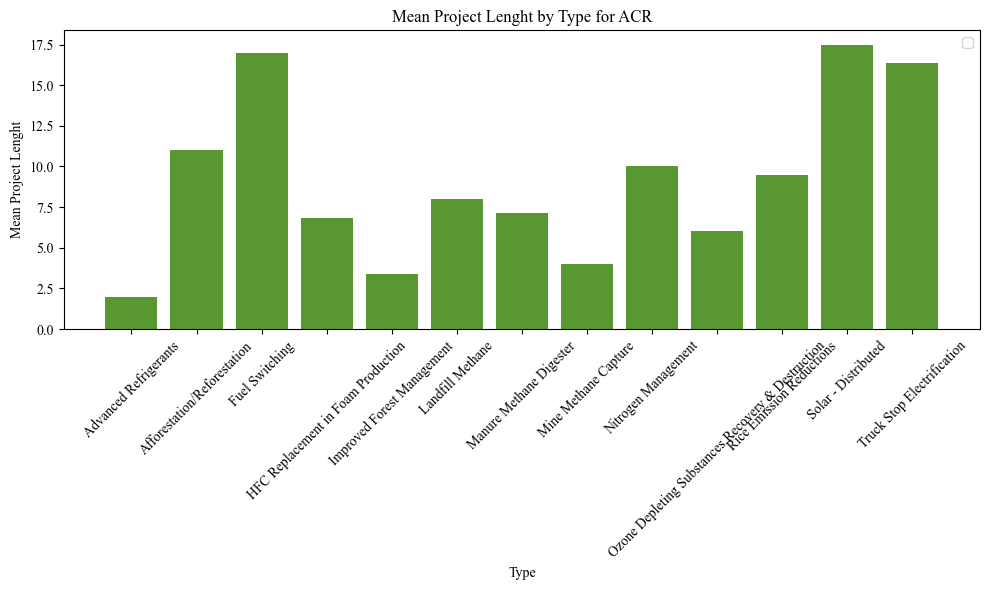

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


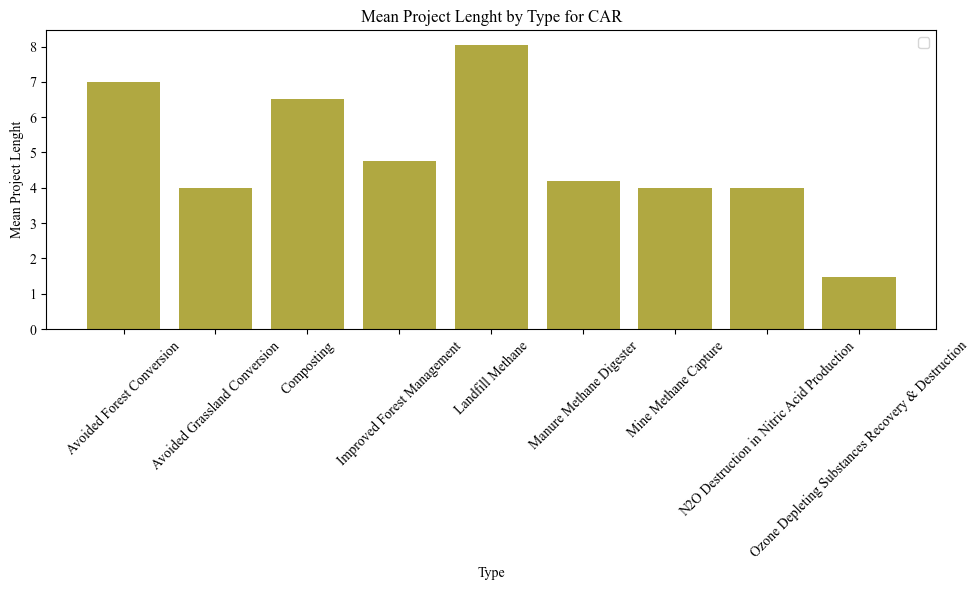

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


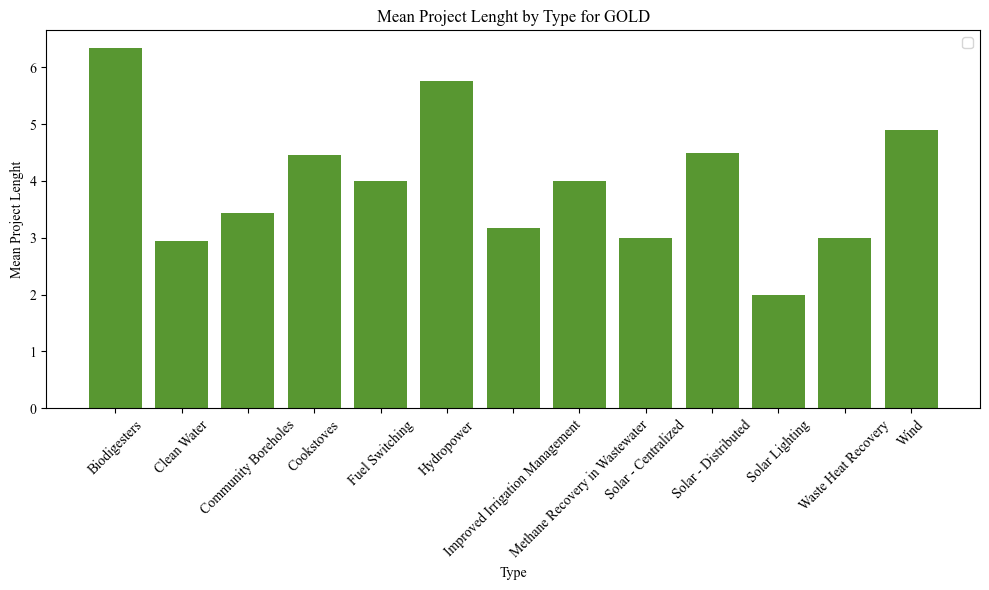

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


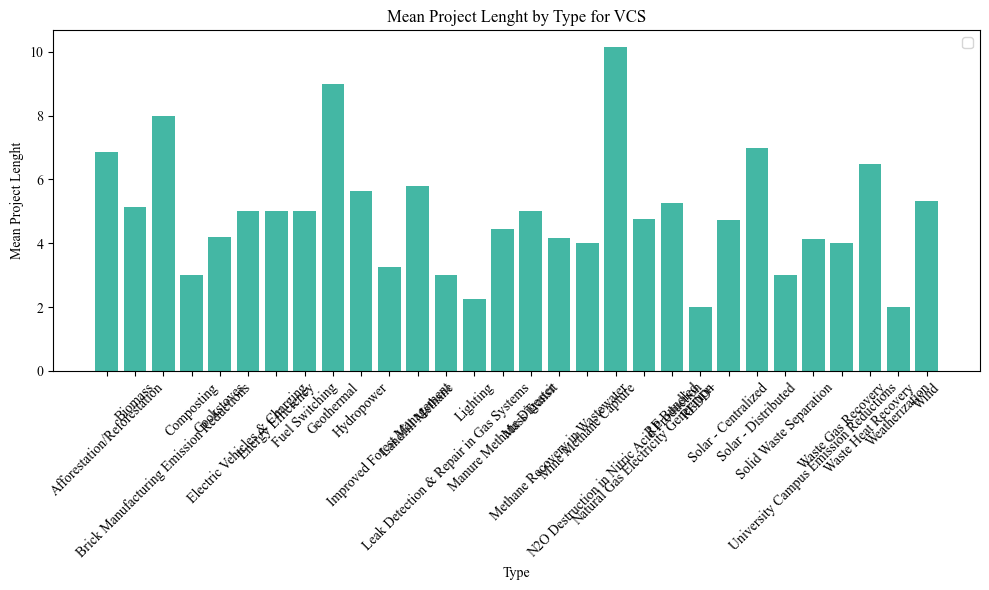

In [70]:
grouped_data = data.groupby(['Voluntary Registry','Region', 'Scope'])['unitary_cost'].mean().reset_index()


# Iterate over unique Voluntary Registries and create separate plots for each registry
for registry in finished_lenght_data['Voluntary Registry'].unique():
    registry_data = finished_lenght_data[finished_lenght_data['Voluntary Registry'] == registry]
    
    # Plotting the data for the current registry
    plt.figure(figsize=(10, 6))
    
    for region in registry_data['Type'].unique():

        plt.bar(registry_data['Type'], registry_data['project_timeline'], alpha=0.7)
        #plt.text(region, sized_data['Project Size'].iloc[region] + 1000, f'Projects: {region}', ha='center')

        
    plt.xlabel('Type')
    plt.ylabel('Mean Project Lenght')
    plt.title(f'Mean Project Lenght by Type for {registry}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [71]:
timeline = data.groupby(['Scope'])[['project_timeline']].mean().reset_index()

In [72]:
timeline

Scope  project_timeline
0               Agriculture          5.496296
1  Carbon Capture & Storage         16.666667
2        Chemical Processes          3.542857
3       Forestry & Land Use          6.374126
4     Household & Community          6.337500
5   Industrial & Commercial          6.059113
6          Renewable Energy          7.530314
7            Transportation         13.510638
8          Waste Management          7.950769

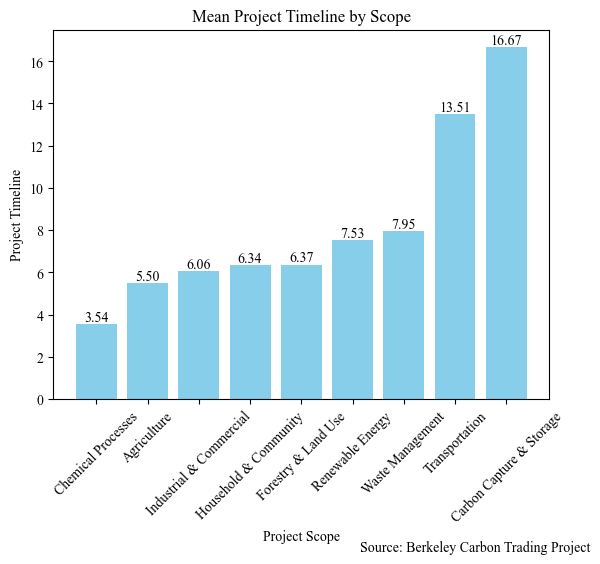

In [73]:
timeline = timeline.sort_values('project_timeline')

plt.bar(timeline['Scope'], timeline['project_timeline'], color='skyblue')

for i, cost in enumerate(timeline['project_timeline']):
    plt.text(i, cost, f'{cost:.2f}', ha='center', va='bottom', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel('Project Scope')
plt.ylabel('Project Timeline')
plt.title('Mean Project Timeline by Scope')
plt.text(0.85, -0.4, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Show the chart
plt.show()

In [74]:
timeline = data.groupby(['Voluntary Registry','Voluntary Status'])[['project_timeline']].mean().reset_index()
timeline

Voluntary Registry                                   Voluntary Status   
0                 ACR                                           Canceled  \
1                 ACR                                          Completed   
2                 ACR                                         Registered   
3                 ACR                                                 nd   
4                 CAR                                          Completed   
5                 CAR                                             Listed   
6                 CAR                                         Registered   
7                 CAR                                       Transitioned   
8                GOLD                     Gold Standard Certified Design   
9                GOLD                    Gold Standard Certified Project   
10               GOLD                                             Listed   
11                VCS                 Crediting Period Renewal Requested   
12                VCS  Crediting Period Renewal and Verification Appr...   
13                VCS                                            On Hold   
14                VCS                                         Registered   
15                VCS                          Rejected by Administrator   
16                VCS                    Transfer to another GHG program   
17                VCS        Units Transferred from Approved GHG Program   
18                VCS                                          Withdrawn   

    project_timeline  
0          11.000000  
1           9.345912  
2           3.684932  
3           4.453271  
4           3.863636  
5           4.000000  
6           6.398204  
7          10.750000  
8           4.285714  
9           6.446244  
10          3.000000  
11         10.545455  
12          7.500000  
13          4.925926  
14          7.581716  
15          6.000000  
16          3.000000  
17          6.828571  
18          6.909091

In [75]:
timeline = timeline[timeline['Voluntary Status'] == 'Completed']
timeline

Voluntary Registry Voluntary Status  project_timeline
1                ACR        Completed          9.345912
4                CAR        Completed          3.863636

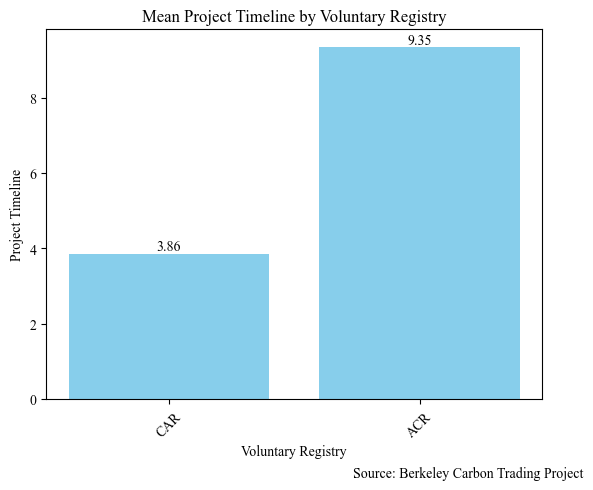

In [76]:
timeline = timeline.sort_values('project_timeline')

plt.bar(timeline['Voluntary Registry'], timeline['project_timeline'], color='skyblue')

for i, cost in enumerate(timeline['project_timeline']):
    plt.text(i, cost, f'{cost:.2f}', ha='center', va='bottom', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel('Voluntary Registry')
plt.ylabel('Project Timeline')
plt.title('Mean Project Timeline by Voluntary Registry')
plt.text(0.85, -0.2, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Show the chart
plt.show()

## **Certifier visualisation**
The next graphs and visuaisations were computed for the better understanding of the impact of a single certifier on certification process costs. For eaxmple:
- what's most expensive issuance or fixed fees, 
- the total and average cost of registring a project by methodology/scope

- the unitary fees of a projeect per credit
  - for example: we can see where Project ID = VCS1 that the certification fees will amount to 1.397936$/ per credit

In [77]:
data.describe()

First Year of Project  project_timeline  Total Credits Issued   
count            4168.000000       4168.000000          4.168000e+03  \
mean             2013.617802          6.672025          4.329243e+05   
std                 4.760200          4.015827          1.743702e+06   
min              1996.000000          1.000000          2.000000e+00   
25%              2010.000000          4.000000          3.281975e+04   
50%              2014.000000          6.000000          8.580150e+04   
75%              2018.000000          9.000000          2.924808e+05   
max              2022.000000         26.000000          3.999829e+07   

       Total Credits Retired  Total Credits Remaining   
count           4.168000e+03             4.168000e+03  \
mean            2.326087e+05             2.003156e+05   
std             9.354998e+05             1.050428e+06   
min             0.000000e+00            -8.140100e+04   
25%             4.624750e+03             6.020000e+02   
50%             3.558400e+04             2.444550e+04   
75%             1.380060e+05             1.086892e+05   
max             2.308066e+07             3.366741e+07   

       Estimated Annual Emission Reductions  Total Fixed Fees   
count                          4.168000e+03       4168.000000  \
mean                           1.094911e+05      30659.259725   
std                            5.515379e+05      19031.638164   
min                            0.000000e+00       7000.000000   
25%                            0.000000e+00      17874.074074   
50%                            2.127150e+04      27667.682927   
75%                            6.979650e+04      37500.000000   
max                            2.668633e+07     187500.000000   

       Total Issuance Fees    Total Fees      VVB Fees  unitary_cost   
count         4.168000e+03  4.168000e+03   1076.000000   4168.000000  \
mean          8.887219e+04  1.199596e+05  12778.345725     16.025394   
std           3.487924e+05  3.491969e+05   8721.685641    711.739172   
min           3.000000e-01  9.061800e+03   4000.000000      0.153157   
25%           6.517800e+03  3.324555e+04   5500.000000      0.305628   
50%           1.752635e+04  5.179929e+04  10000.000000      0.509542   
75%           5.945780e+04  9.677237e+04  16000.000000      1.072991   
max           7.999658e+06  8.020658e+06  49000.000000  45250.170000   

       percentage_of_fixed  
count          4168.000000  
mean             54.911523  
std              29.232692  
min               0.261824  
25%              29.072275  
50%              57.758122  
75%              81.672284  
max              99.997538

In [78]:
data.Type.unique()

array(['Wind', 'Biomass', 'Hydropower', 'Afforestation/Reforestation',
       'Landfill Methane', 'Mine Methane Capture', 'REDD+',
       'Leak Detection & Repair in Gas Systems',
       'Brick Manufacturing Emission Reductions',
       'Improved Forest Management', 'RE Bundled',
       'University Campus Emission Reductions',
       'Methane Recovery in Wastewater', 'Geothermal',
       'Solar - Centralized', 'Natural Gas Electricity Generation',
       'N2O Destruction in Nitric Acid Production',
       'Manure Methane Digester', 'Solar - Distributed', 'Composting',
       'Cookstoves', 'Electric Vehicles & Charging', 'Waste Gas Recovery',
       'Waste Heat Recovery', 'Energy Efficiency', 'Fuel Switching',
       'Mass Transit', 'Lighting', 'Solid Waste Separation',
       'Weatherization', 'Clean Water', 'Improved Irrigation Management',
       'Community Boreholes', 'Solar Lighting', 'Biodigesters',
       'Ozone Depleting Substances Recovery & Destruction',
       'Avoided Forest

C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\4284702093.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  try_1['Fixed Costs'] = try_1['Fixed Costs'].apply(lambda x: {int(index + 1): value for index, (key, value) in enumerate(x.items())})
C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\4284702093.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  try_1['Total Fixed Costs'] = try_1['Fixed Costs'].apply(lambda x: sum(x.values()))


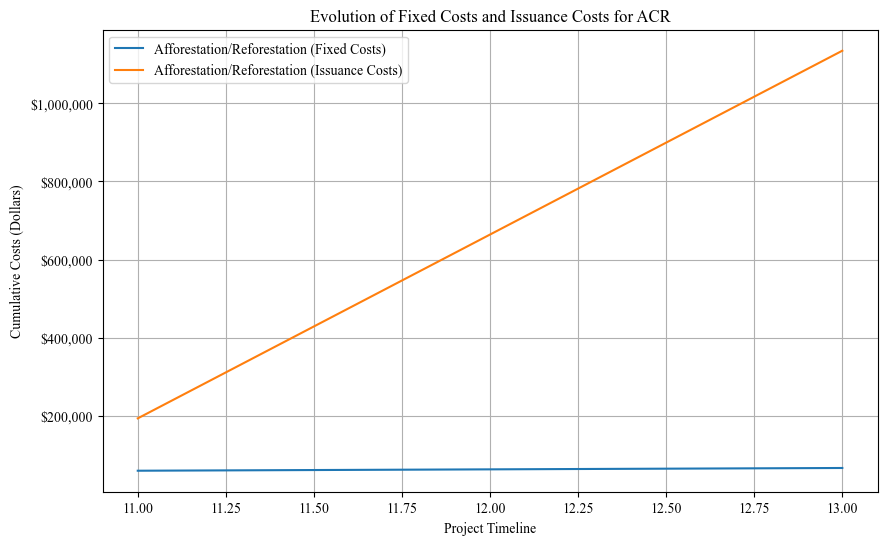

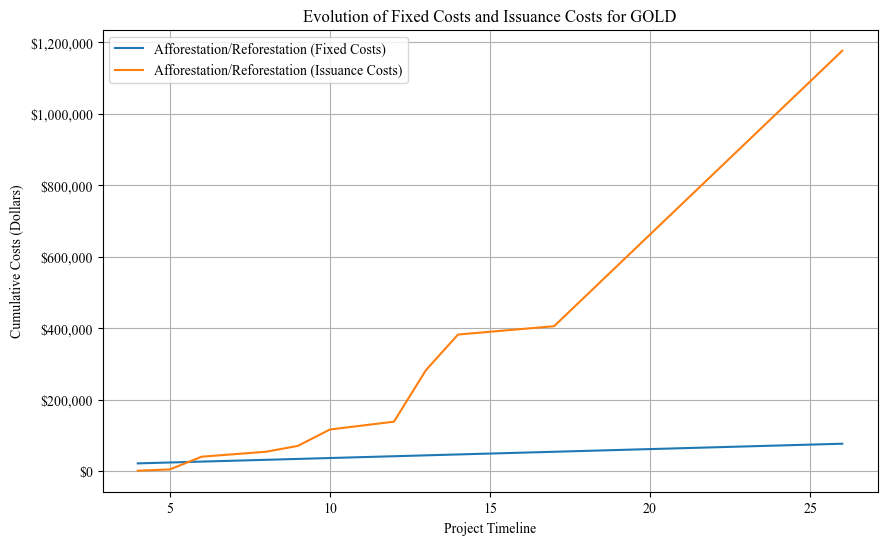

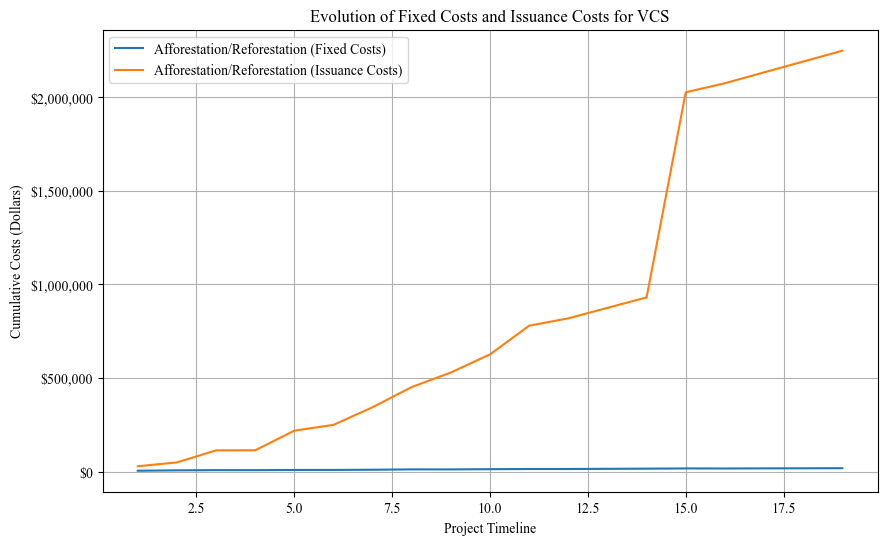

In [79]:
import matplotlib.ticker as mticker

#update this code for this table:
try_1= data[['Voluntary Registry', 'Type', 'project_timeline', 'Total Issuance Fees','Fixed Costs']]

# Assuming try_1 is your DataFrame

try_1['Fixed Costs'] = try_1['Fixed Costs'].apply(lambda x: {int(index + 1): value for index, (key, value) in enumerate(x.items())})

try_1['Total Fixed Costs'] = try_1['Fixed Costs'].apply(lambda x: sum(x.values()))

# List of project types you want to visualize
selected_project_types = ['Afforestation/Reforestation']  # Add the project types you want to include in the visualization

# Filter data for selected project types
filtered_data = try_1[try_1['Type'].isin(selected_project_types)]


# Group data by 'Voluntary Registry', 'Type', and 'project_timeline' and calculate averages
grouped_data = filtered_data.groupby(['Voluntary Registry', 'Type', 'project_timeline']).agg({
    'Total Fixed Costs': 'mean',
    'Total Issuance Fees': 'mean'
}).reset_index()

# Calculate evolution of fixed costs and issuance costs over project timeline
grouped_data['Issuance Costs Evolution'] = grouped_data.groupby(['Voluntary Registry', 'Type'])['Total Issuance Fees'].cumsum()

# Create separate plots for different registries
registries = grouped_data['Voluntary Registry'].unique()

for registry in registries:
    subset = grouped_data[grouped_data['Voluntary Registry'] == registry]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for project_type, group in subset.groupby('Type'):
        ax.plot(group['project_timeline'], group['Total Fixed Costs'], label=f'{project_type} (Fixed Costs)')
        ax.plot(group['project_timeline'], group['Issuance Costs Evolution'], label=f'{project_type} (Issuance Costs)')
    
    plt.xlabel('Project Timeline')
    plt.ylabel('Cumulative Costs (Dollars)')
    plt.title(f'Evolution of Fixed Costs and Issuance Costs for {registry}')
    plt.legend()
    plt.grid(True)
    
    # Format y-axis labels to display dollar values
    ax.get_yaxis().set_major_formatter(mticker.StrMethodFormatter('${x:,.0f}'))
    
    plt.show()

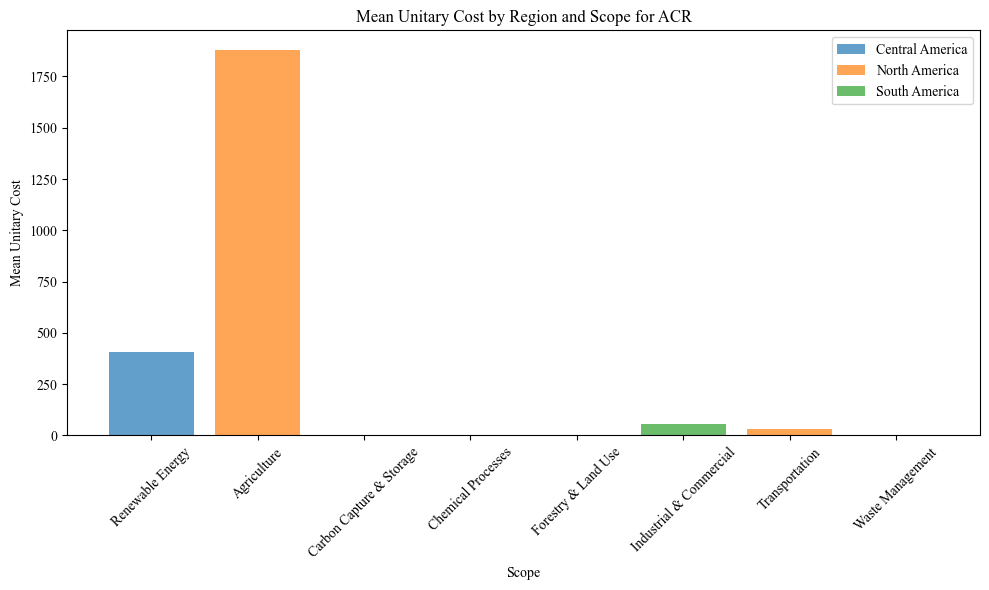

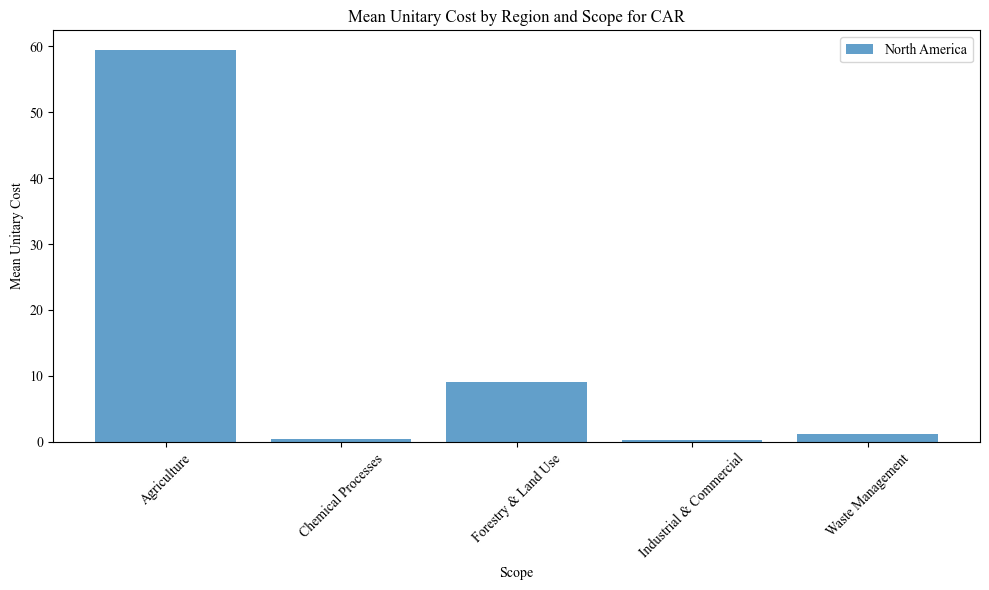

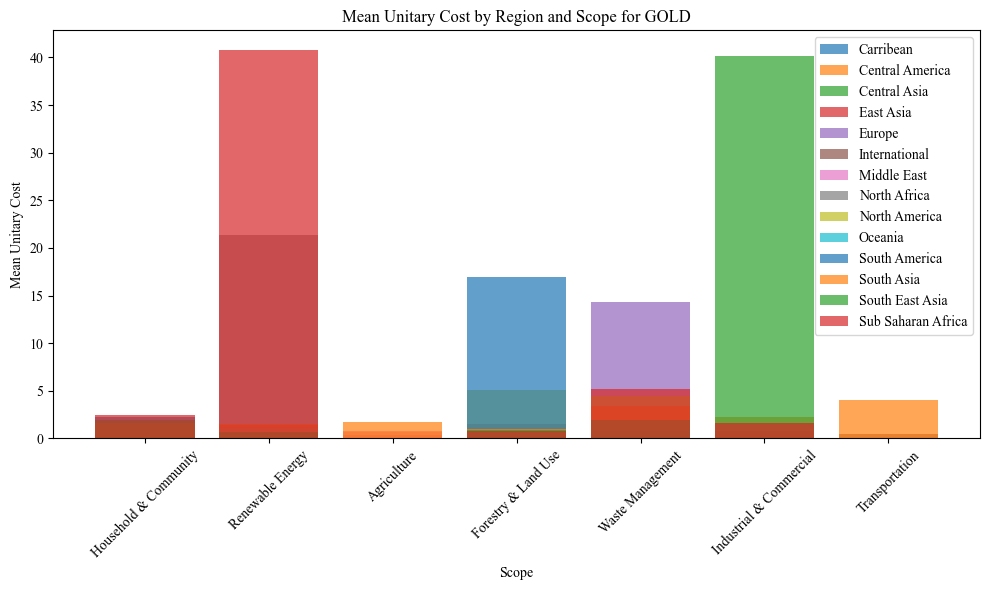

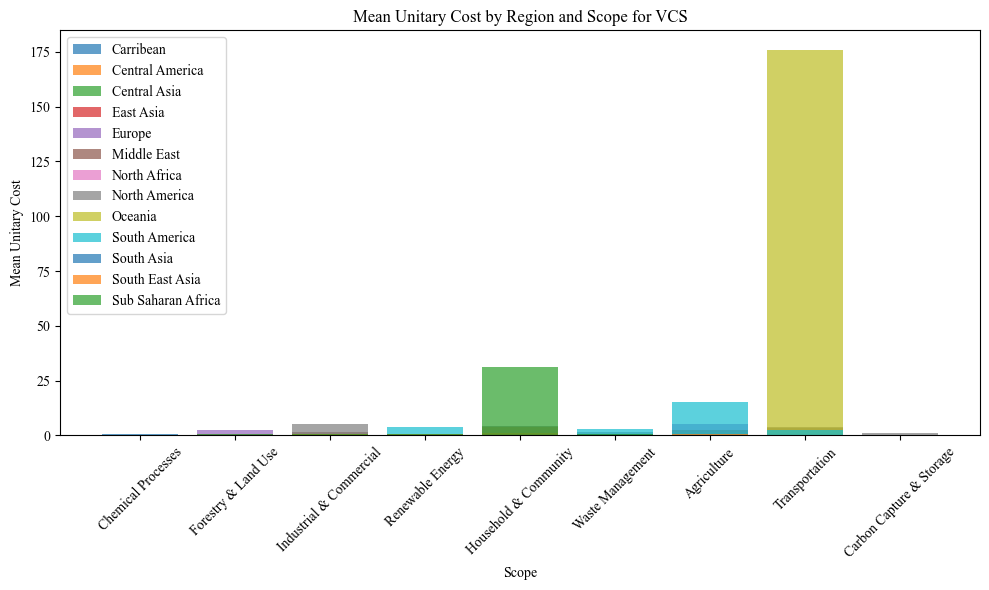

In [80]:
# Assuming your grouped data is stored in a variable called 'grouped_data'
grouped_data = data.groupby(['Voluntary Registry','Region', 'Scope'])['unitary_cost'].mean().reset_index()


# Iterate over unique Voluntary Registries and create separate plots for each registry
for registry in grouped_data['Voluntary Registry'].unique():
    registry_data = grouped_data[grouped_data['Voluntary Registry'] == registry]
    
    # Plotting the data for the current registry
    plt.figure(figsize=(10, 6))
    
    for region in registry_data['Region'].unique():
        region_data = registry_data[registry_data['Region'] == region]
        plt.bar(region_data['Scope'], region_data['unitary_cost'], label=region, alpha=0.7)
    
    plt.xlabel('Scope')
    plt.ylabel('Mean Unitary Cost')
    plt.title(f'Mean Unitary Cost by Region and Scope for {registry}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [81]:
data.Scope

0         Renewable Energy
1         Renewable Energy
2         Renewable Energy
3         Renewable Energy
4         Renewable Energy
               ...        
4177    Chemical Processes
4180    Chemical Processes
4185    Chemical Processes
4186    Chemical Processes
4189    Chemical Processes
Name: Scope, Length: 4168, dtype: object

In [82]:
sample = data.groupby(['Voluntary Registry', 'Scope'])[['unitary_cost']].median().reset_index()

In [83]:
cleaned = sample[~((sample['Voluntary Registry'] == 'ACR') & (sample['Scope'] == 'Agriculture'))]


In [84]:
sample

Voluntary Registry                     Scope  unitary_cost
0                 ACR               Agriculture      1.310277
1                 ACR  Carbon Capture & Storage      0.182967
2                 ACR        Chemical Processes      0.836253
3                 ACR       Forestry & Land Use      0.288272
4                 ACR   Industrial & Commercial      0.941483
5                 ACR          Renewable Energy      0.262083
6                 ACR            Transportation     11.898167
7                 ACR          Waste Management      0.781805
8                 CAR               Agriculture      0.885242
9                 CAR        Chemical Processes      0.410628
10                CAR       Forestry & Land Use      1.147890
11                CAR   Industrial & Commercial      0.252065
12                CAR          Waste Management      0.412660
13               GOLD               Agriculture      0.554853
14               GOLD       Forestry & Land Use      0.692306
15               GOLD     Household & Community      1.071583
16               GOLD   Industrial & Commercial      0.567047
17               GOLD          Renewable Energy      0.516473
18               GOLD            Transportation      0.612483
19               GOLD          Waste Management      0.716961
20                VCS               Agriculture      0.382002
21                VCS  Carbon Capture & Storage      1.022989
22                VCS        Chemical Processes      0.259423
23                VCS       Forestry & Land Use      0.234400
24                VCS     Household & Community      0.457240
25                VCS   Industrial & Commercial      0.281300
26                VCS          Renewable Energy      0.331618
27                VCS            Transportation      3.160181
28                VCS          Waste Management      0.324074

In [85]:
cleaned

Voluntary Registry                     Scope  unitary_cost
1                 ACR  Carbon Capture & Storage      0.182967
2                 ACR        Chemical Processes      0.836253
3                 ACR       Forestry & Land Use      0.288272
4                 ACR   Industrial & Commercial      0.941483
5                 ACR          Renewable Energy      0.262083
6                 ACR            Transportation     11.898167
7                 ACR          Waste Management      0.781805
8                 CAR               Agriculture      0.885242
9                 CAR        Chemical Processes      0.410628
10                CAR       Forestry & Land Use      1.147890
11                CAR   Industrial & Commercial      0.252065
12                CAR          Waste Management      0.412660
13               GOLD               Agriculture      0.554853
14               GOLD       Forestry & Land Use      0.692306
15               GOLD     Household & Community      1.071583
16               GOLD   Industrial & Commercial      0.567047
17               GOLD          Renewable Energy      0.516473
18               GOLD            Transportation      0.612483
19               GOLD          Waste Management      0.716961
20                VCS               Agriculture      0.382002
21                VCS  Carbon Capture & Storage      1.022989
22                VCS        Chemical Processes      0.259423
23                VCS       Forestry & Land Use      0.234400
24                VCS     Household & Community      0.457240
25                VCS   Industrial & Commercial      0.281300
26                VCS          Renewable Energy      0.331618
27                VCS            Transportation      3.160181
28                VCS          Waste Management      0.324074

In [86]:
sample = cleaned.groupby(['Voluntary Registry'])[['unitary_cost']].median().reset_index()

In [87]:
sample

Voluntary Registry  unitary_cost
0                ACR      0.781805
1                CAR      0.412660
2               GOLD      0.612483
3                VCS      0.331618

In [88]:
sample2 = data.groupby(['Scope'])[['unitary_cost']].median().reset_index()

In [89]:
sample2

Scope  unitary_cost
0               Agriculture      0.748450
1  Carbon Capture & Storage      0.189290
2        Chemical Processes      0.576294
3       Forestry & Land Use      0.328771
4     Household & Community      1.012645
5   Industrial & Commercial      0.325012
6          Renewable Energy      0.380157
7            Transportation      7.867899
8          Waste Management      0.374449

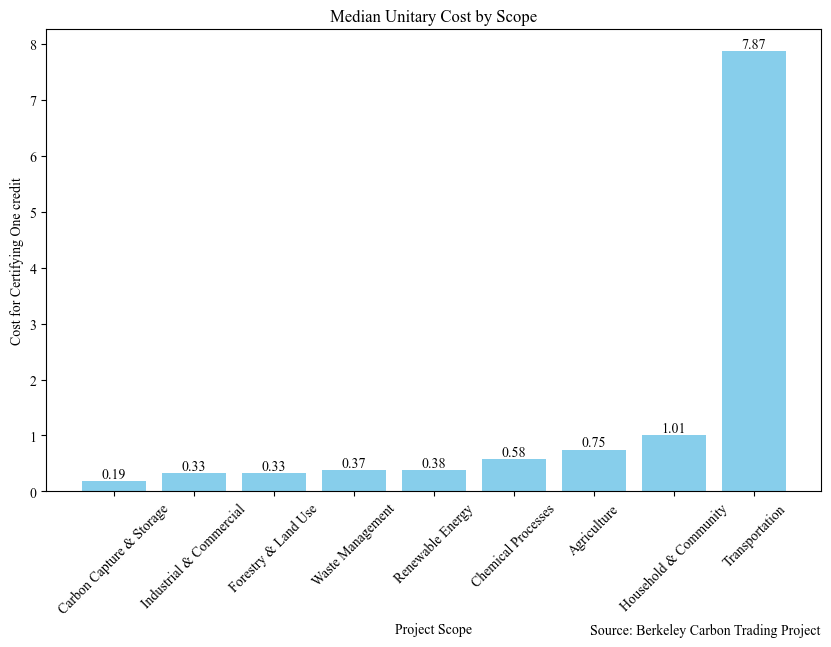

In [174]:
# Set the figure size
plt.figure(figsize=(10, 6))

sample2 = sample2.sort_values('unitary_cost')
# Create a bar chart
plt.bar(sample2['Scope'], sample2['unitary_cost'], color='skyblue')

for i, cost in enumerate(sample2['unitary_cost']):
    plt.text(i, cost, f'{cost:.2f}', ha='center', va='bottom', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel('Project Scope')
plt.ylabel('Cost for Certifying One credit')
plt.title('Median Unitary Cost by Scope')
plt.text(0.85, -0.3, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Show the chart
plt.show()

In [91]:
sample3 = data.groupby(['Scope'])[['unitary_cost']].mean().reset_index()

In [92]:
desired_order = ['Carbon Capture & Storage', 'Industrial & Commercial', 'Forestry & Land Use','Waste Management','Renewable Energy', 'Chemical Processes', 'Agriculture', 'Household & Community', 'Transportation']

# Create a mapping of elements to their desired positions
mapping = {element: index for index, element in enumerate(desired_order)}


In [93]:
# Reorder values in 'Column_Name' based on desired_order for both DataFrames
sample2['Scope'] = sample2['Scope'].astype(
    pd.CategoricalDtype(desired_order, ordered=True)
)
sample2 = sample2.sort_values('Scope').reset_index(drop=True)

sample3['Scope'] = sample3['Scope'].astype(
    pd.CategoricalDtype(desired_order, ordered=True)
)
sample3 = sample3.sort_values('Scope').reset_index(drop=True)

# Displaying the updated DataFrames
print("Updated sample2:")
print(sample2)

print("\nUpdated sample3:")
print(sample3)

Updated sample2:
                      Scope  unitary_cost
0  Carbon Capture & Storage      0.189290
1   Industrial & Commercial      0.325012
2       Forestry & Land Use      0.328771
3          Waste Management      0.374449
4          Renewable Energy      0.380157
5        Chemical Processes      0.576294
6               Agriculture      0.748450
7     Household & Community      1.012645
8            Transportation      7.867899

Updated sample3:
                      Scope  unitary_cost
0  Carbon Capture & Storage      0.322198
1   Industrial & Commercial      2.080849
2       Forestry & Land Use      4.007138
3          Waste Management      1.279613
4          Renewable Energy      2.021619
5        Chemical Processes      1.041555
6               Agriculture    208.338596
7     Household & Community      3.011651
8            Transportation     26.667329


In [94]:
sample4 = sample3

In [95]:
sample4_diff = 100* abs(sample2['unitary_cost'] - sample3['unitary_cost'])/sample3['unitary_cost']

In [96]:
sample4['unitary_cost'] = sample4_diff

In [97]:
sample4

Scope  unitary_cost
0  Carbon Capture & Storage     41.250441
1   Industrial & Commercial     84.380816
2       Forestry & Land Use     91.795356
3          Waste Management     70.737346
4          Renewable Energy     81.195443
5        Chemical Processes     44.669890
6               Agriculture     99.640753
7     Household & Community     66.375765
8            Transportation     70.496111

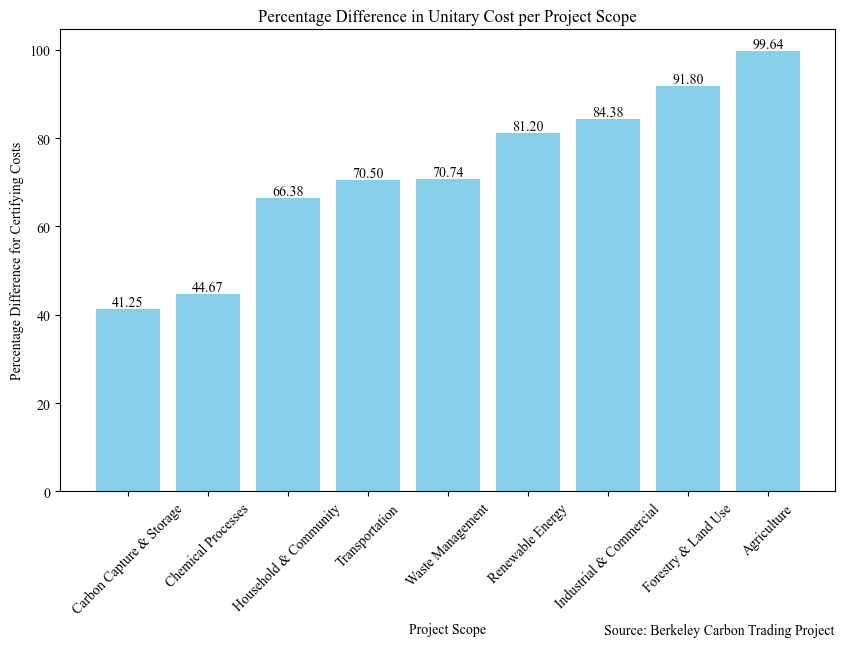

In [98]:
# Set the figure size
plt.figure(figsize=(10, 6))

sample4 = sample4.sort_values('unitary_cost')
# Create a bar chart
plt.bar(sample4['Scope'], sample4['unitary_cost'], color='skyblue')

for i, cost in enumerate(sample4['unitary_cost']):
    plt.text(i, cost, f'{cost:.2f}', ha='center', va='bottom', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel('Project Scope')
plt.ylabel('Percentage Difference for Certifying Costs')
plt.title('Percentage Difference in Unitary Cost per Project Scope')
plt.text(0.85, -0.3, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Show the chart
plt.show()


In [99]:
issued_credits = data.groupby(['Scope'])[['Total Credits Issued']].median().reset_index()

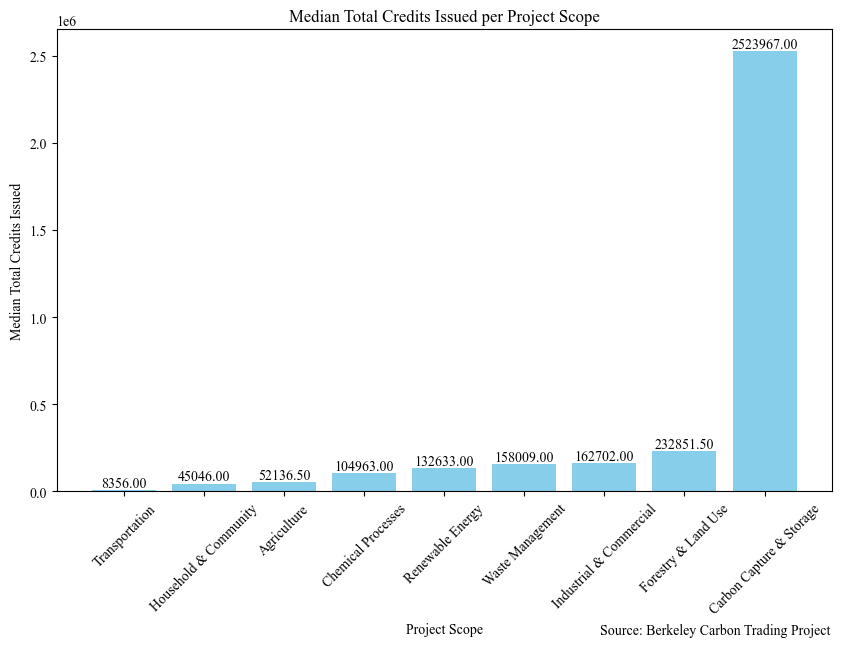

In [100]:
# Set the figure size
plt.figure(figsize=(10, 6))

issued_credits = issued_credits.sort_values('Total Credits Issued')
# Create a bar chart
plt.bar(issued_credits['Scope'], issued_credits['Total Credits Issued'], color='skyblue')

for i, cost in enumerate(issued_credits['Total Credits Issued']):
    plt.text(i, cost, f'{cost:.2f}', ha='center', va='bottom', color='black')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.xlabel('Project Scope')
plt.ylabel('Median Total Credits Issued')
plt.title('Median Total Credits Issued per Project Scope')
plt.text(0.85, -0.3, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Show the chart
plt.show()


### Number of Projects

In [101]:
project_counts = df['Scope'].value_counts().reset_index()

print(project_counts)

                      Scope  count
0          Renewable Energy   1435
1     Household & Community    960
2       Forestry & Land Use    574
3        Chemical Processes    362
4          Waste Management    325
5               Agriculture    270
6   Industrial & Commercial    211
7            Transportation     47
8  Carbon Capture & Storage      6


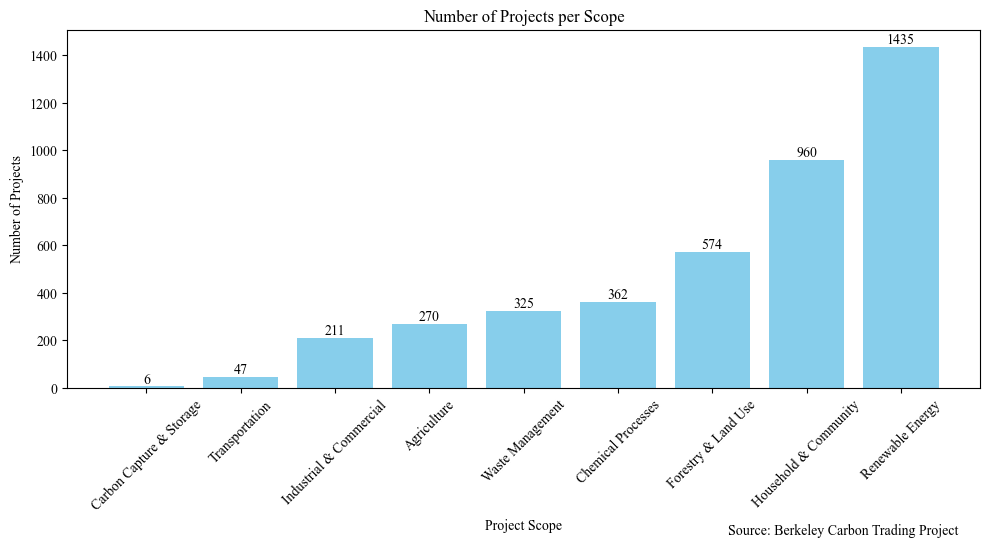

In [102]:
plt.figure(figsize=(10, 6))

project_counts = project_counts.sort_values('count')
plt.bar(project_counts['Scope'], project_counts['count'], color='skyblue')

# Adding labels and title
plt.xlabel('Project Scope')
plt.ylabel('Number of Projects')
plt.title('Number of Projects per Scope')
plt.text(0.85, -0.4, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
# Rotating x-axis labels for better readability if needed
plt.xticks(rotation=45)

for i, count in enumerate(project_counts['count']):
    plt.text(i, count + 0.5, str(count), ha='center', va='bottom', color='black')


# Show the plot
plt.tight_layout()
plt.show()

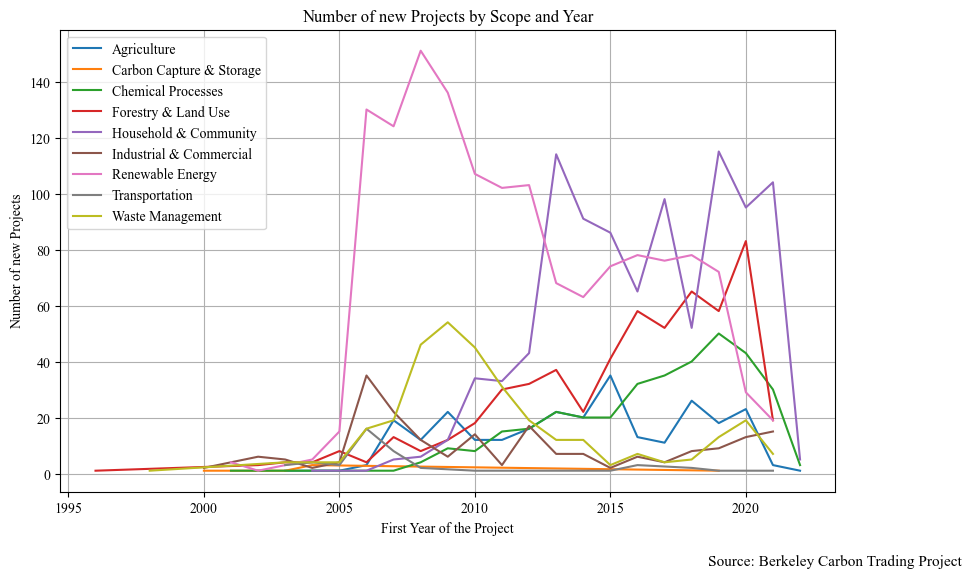

In [140]:
project_counts = data.groupby(['Scope', 'First Year of Project']).size().reset_index(name='project_count')
project_counts_filt = project_counts[project_counts['First Year of Project'] < 2023]

plt.figure(figsize=(10, 6)) 
scopes = project_counts_filt['Scope'].unique()
for scope in scopes:
    data2 = project_counts_filt[project_counts_filt['Scope'] == scope]
    plt.plot(data2['First Year of Project'], data2['project_count'], label=scope)


# Plot configurations
plt.xlabel('First Year of the Project')
plt.ylabel('Number of new Projects')
plt.title('Number of new Projects by Scope and Year')
plt.text(1, -0.15, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=11)

plt.legend()
plt.grid(True)
plt.show()

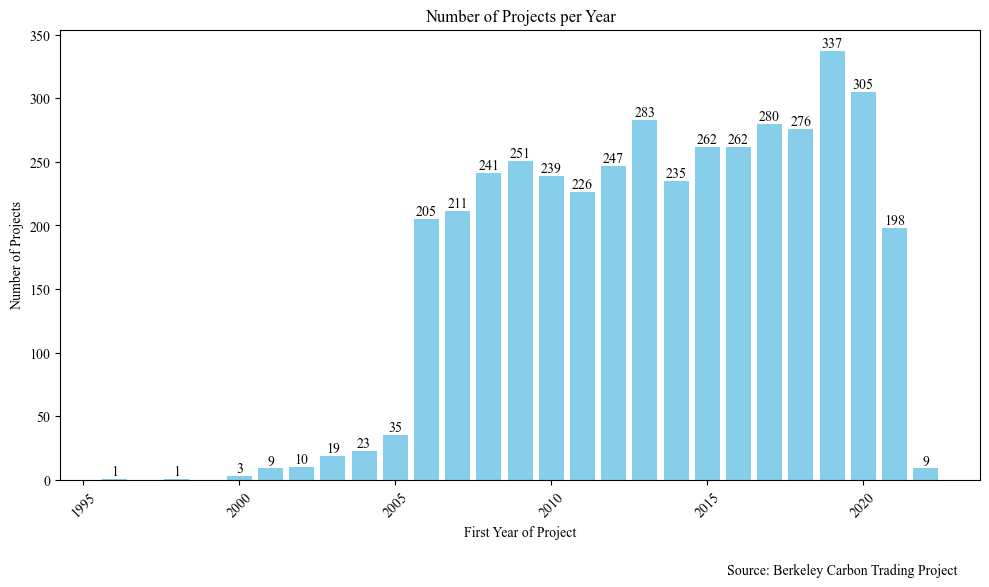

In [141]:

total_projects = project_counts_filt.groupby(['First Year of Project'])[['project_count']].sum().reset_index()
plt.figure(figsize=(10, 6))

# Plotting the bar chart with sky blue color
bars = plt.bar(total_projects['First Year of Project'], total_projects['project_count'], color='skyblue')

# Adding numbers on the bars
for bar, count in zip(bars, total_projects['project_count']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, str(count),
             ha='center', va='bottom', color='black')

# Adding labels and title
plt.xlabel('First Year of Project')
plt.ylabel('Number of Projects')
plt.title('Number of Projects per Year')
plt.text(0.85, -0.2, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Rotating x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

## Issuance Trends

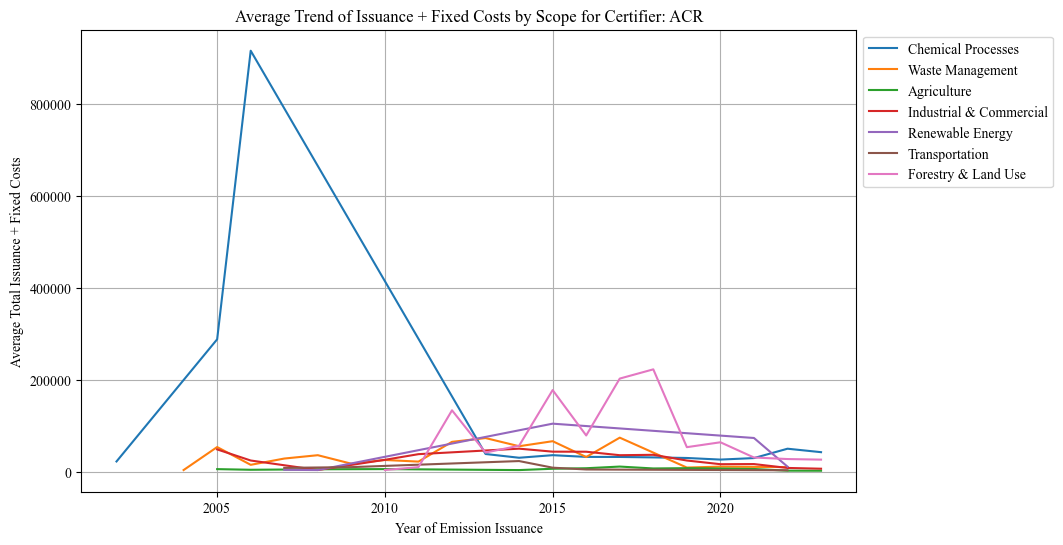

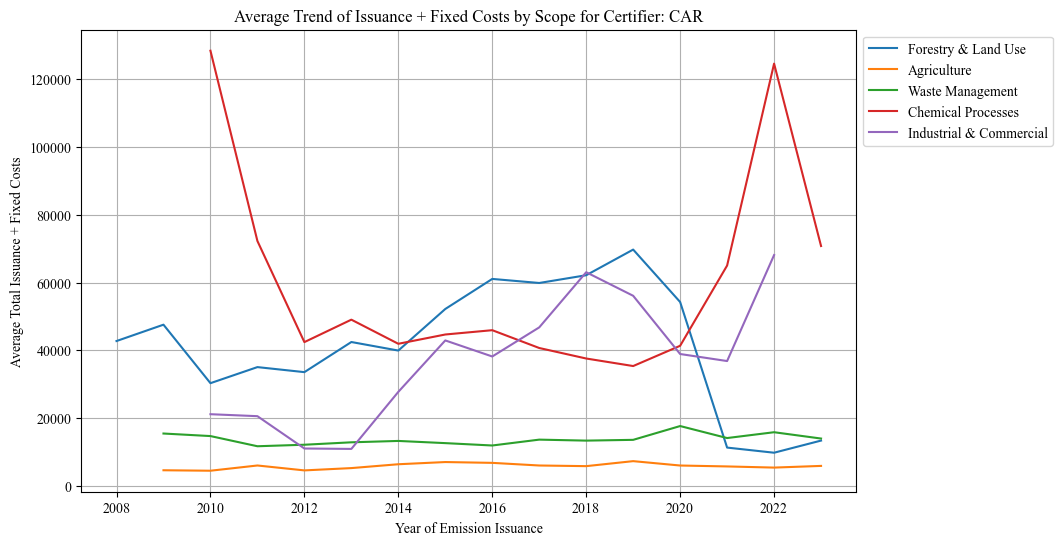

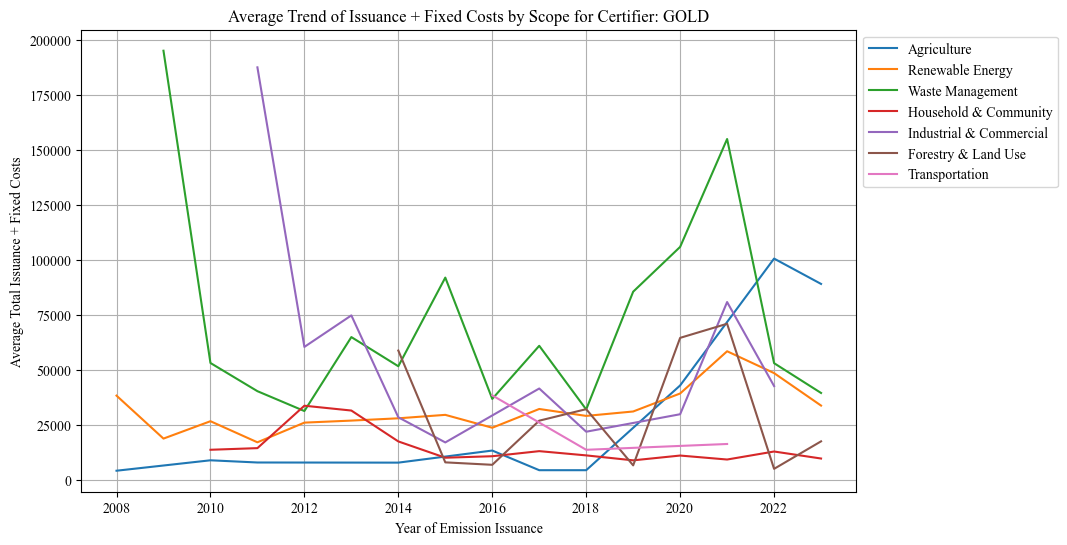

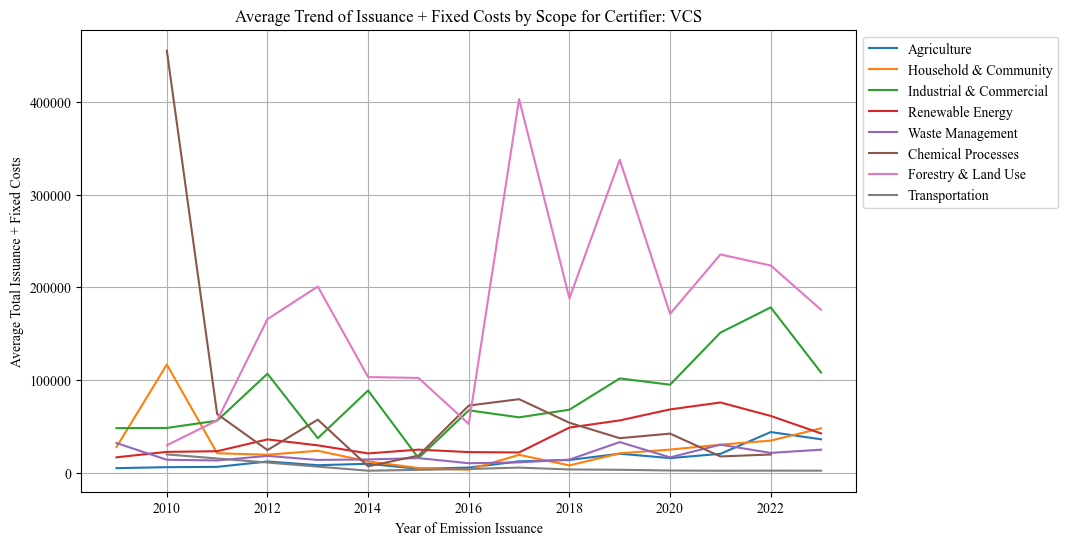

In [105]:
# Create an empty list to store data for plotting
plot_data = []

# Iterate through unique certifiers in the 'Certifier' column
for certifier in merged_df['Voluntary Registry'].unique():
    certifier_data = merged_df[merged_df['Voluntary Registry'] == certifier]
    
    # Iterate through rows and extract data for plotting for the current certifier
    for index, row in certifier_data.iterrows():
        for year, issuance_fee in row['Issuance Fees'].items():
            # Get the fixed fee for the current year from the 'Fixed Costs' column
            fixed_fee = row['Fixed Costs'].get(year, 0)
            # Calculate total cost for the current year by adding issuance fee and fixed fee
            total_cost = issuance_fee + fixed_fee
            # Append data to the plot_data list along with the certifier information
            plot_data.append({'Certifier': certifier, 'Scope': row['Scope'], 'Year': int(year), 'Total Cost': total_cost})

# Create a DataFrame from the list of dictionaries
plot_df = pd.DataFrame(plot_data)

# Calculate average total cost by certifier, scope, and year
average_costs = plot_df.groupby(['Certifier', 'Year', 'Scope'])['Total Cost'].mean().reset_index()

# Plotting for each certifier
for certifier in average_costs['Certifier'].unique():
    certifier_data = average_costs[average_costs['Certifier'] == certifier]
    plt.figure(figsize=(10, 6))
    
    # Iterate over unique 'Scope' values and plot average trend lines for the current certifier
    for scope in certifier_data['Scope'].unique():
        if scope == 'Carbon Capture & Storage':
            continue
        else:
            scope_data = certifier_data[certifier_data['Scope'] == scope]
            plt.plot(scope_data['Year'], scope_data['Total Cost'], label=scope)
    
    plt.xlabel('Year of Emission Issuance')
    plt.ylabel('Average Total Issuance + Fixed Costs')
    plt.title(f'Average Trend of Issuance + Fixed Costs by Scope for Certifier: {certifier}')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(True)
    plt.show()

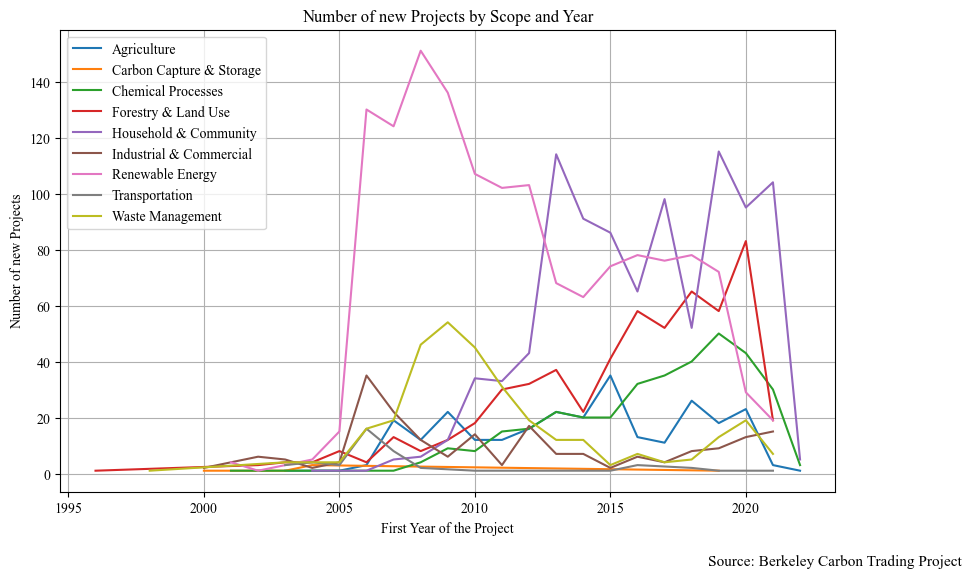

In [106]:
project_counts = data.groupby(['Scope', 'First Year of Project']).size().reset_index(name='project_count')
project_counts_filt = project_counts[project_counts['First Year of Project'] < 2023]

plt.figure(figsize=(10, 6)) 
scopes = project_counts_filt['Scope'].unique()
for scope in scopes:
    data2 = project_counts_filt[project_counts_filt['Scope'] == scope]
    plt.plot(data2['First Year of Project'], data2['project_count'], label=scope)


# Plot configurations
plt.xlabel('First Year of the Project')
plt.ylabel('Number of new Projects')
plt.title('Number of new Projects by Scope and Year')
plt.text(1, -0.15, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=11)

plt.legend()
plt.grid(True)
plt.show()

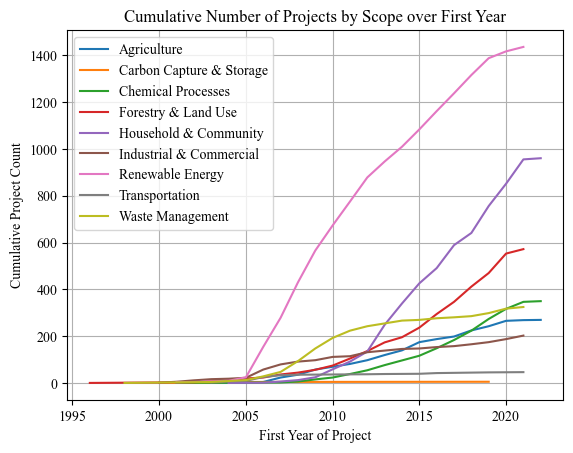

In [107]:
project_counts = project_counts_filt
project_counts['cumulative_sum'] = project_counts.groupby('Scope')['project_count'].cumsum()

# Plotting the cumulative sum
scopes = project_counts['Scope'].unique()
for scope in scopes:
    data2 = project_counts[project_counts['Scope'] == scope]
    plt.plot(data2['First Year of Project'], data2['cumulative_sum'], label=scope)

# Plot configurations
plt.xlabel('First Year of Project')
plt.ylabel('Cumulative Project Count')
plt.title('Cumulative Number of Projects by Scope over First Year')
plt.legend()
plt.grid(True)
plt.show()

### Issuance fees per region

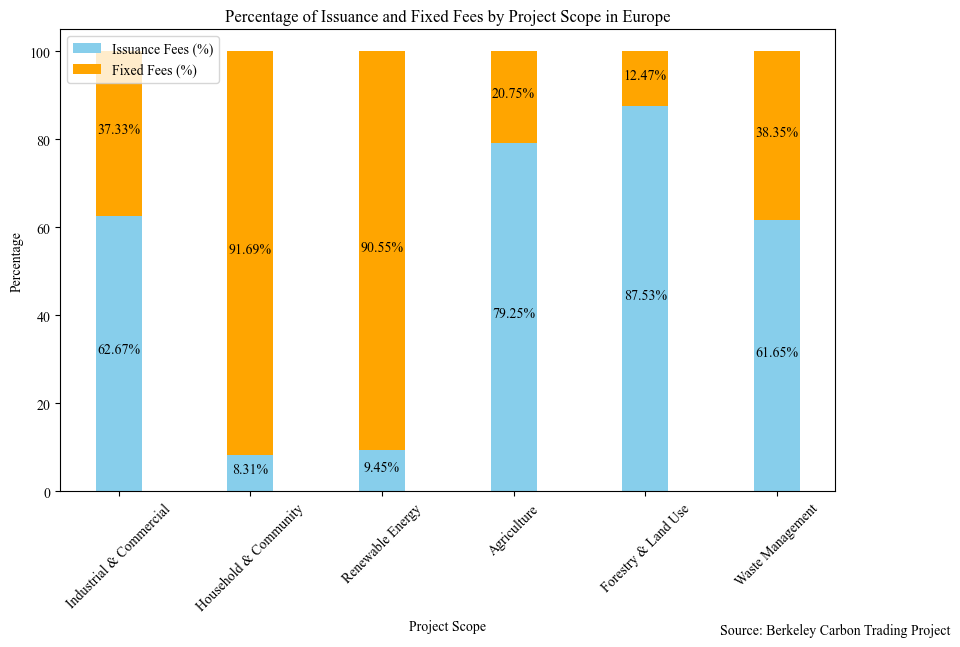

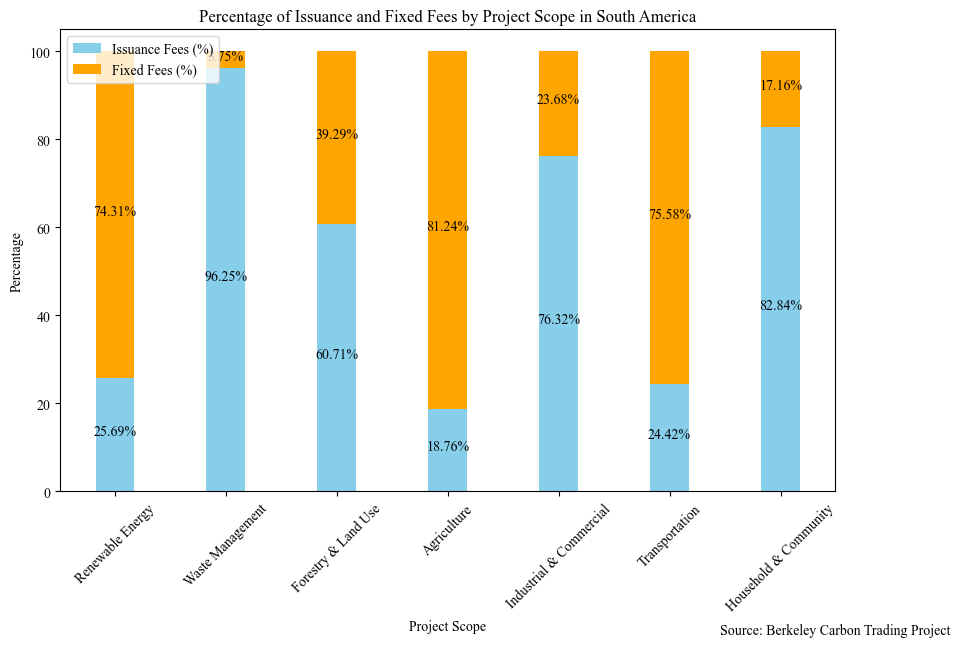

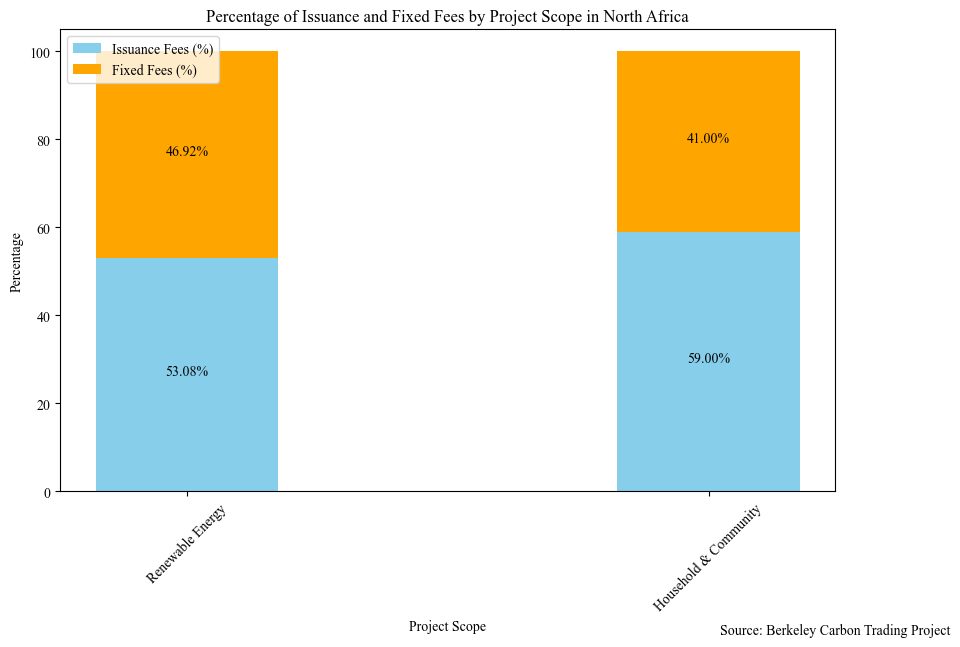

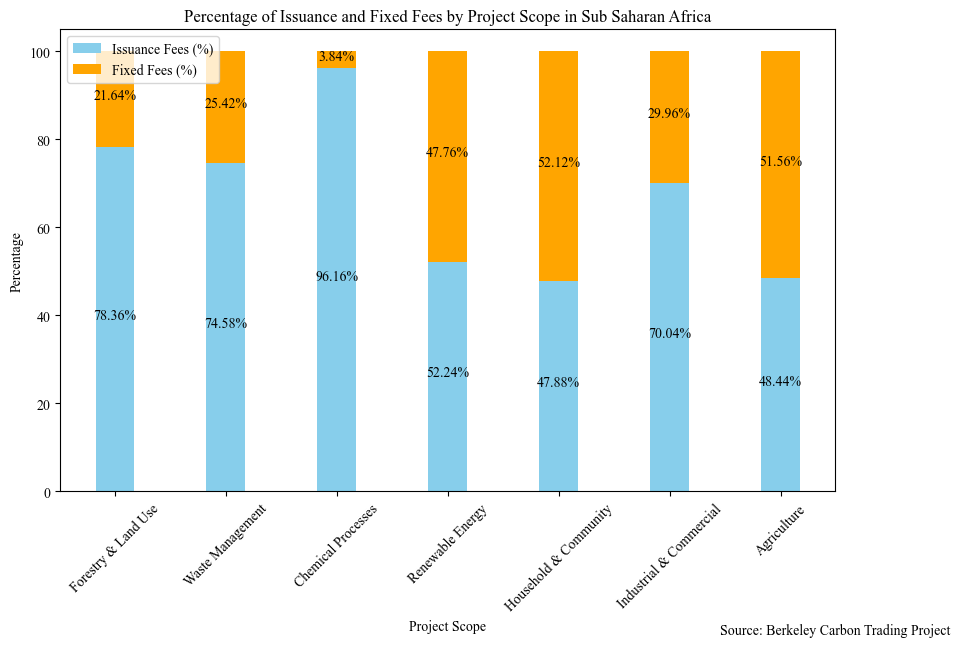

In [176]:
#stats = verra_fees_data.groupby(['Region','Scope']).agg({'Estimated Annual Emission Reductions': 'mean','Total Credits Issued':'mean' ,'Project ID': 'count', 'Total Issuance Fees': 'sum', 'Total Fixed Fees': 'sum' ,'Number of Years':'mean','Total Fees':'mean'}).applymap('{:.2f}'.format).sort_values('Total Fees',ascending=True).reset_index()


stats=data    
# Filter data for each region
regions = stats['Region'].unique()
regions_of_interest = ['Europe', 'South America', 'North Africa', 'Sub Saharan Africa']
# Iterate through each region and create a grouped bar chart
for region in regions_of_interest:
    # Filter data for the current region
    region_data = stats[stats['Region'] == region]
    
    # Project types and average fees for the current region
    project_types = region_data['Scope'].unique()
    average_issuance_fees = region_data.groupby('Scope')['Total Issuance Fees'].mean()
    average_fixed_fees = region_data.groupby('Scope')['Total Fixed Fees'].mean()
    
    # Calculate the percentage of fixed fees and issuance fees for each project type
    total_fees = average_issuance_fees + average_fixed_fees
    issuance_fee_percentage = (average_issuance_fees / total_fees) * 100
    fixed_fee_percentage = (average_fixed_fees / total_fees) * 100
    
    # Set the bar width
    bar_width = 0.35
    
    # Create a grouped bar chart
    ind = np.arange(len(project_types))
    plt.figure(figsize=(10, 6))
    p1 = plt.bar(ind, issuance_fee_percentage, bar_width, label='Issuance Fees (%)', color='skyblue')
    p2 = plt.bar(ind, fixed_fee_percentage, bar_width, label='Fixed Fees (%)', bottom=issuance_fee_percentage, color='orange')
    
    plt.xlabel('Project Scope')
    plt.ylabel('Percentage')
    plt.title(f'Percentage of Issuance and Fixed Fees by Project Scope in {region}')
    plt.xticks(ind, project_types, rotation=45)
    plt.legend(loc='upper left')
    plt.text(1, -0.3, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)
    
    # Add percentage labels on the bars
    for index, (issuance_percentage, fixed_percentage) in enumerate(zip(issuance_fee_percentage, fixed_fee_percentage)):
        plt.text(index, issuance_percentage/2, f'{issuance_percentage:.2f}%', ha='center', color='black')
        plt.text(index, issuance_percentage + fixed_percentage/2, f'{fixed_percentage:.2f}%', ha='center', color='black')
    
    plt.show()

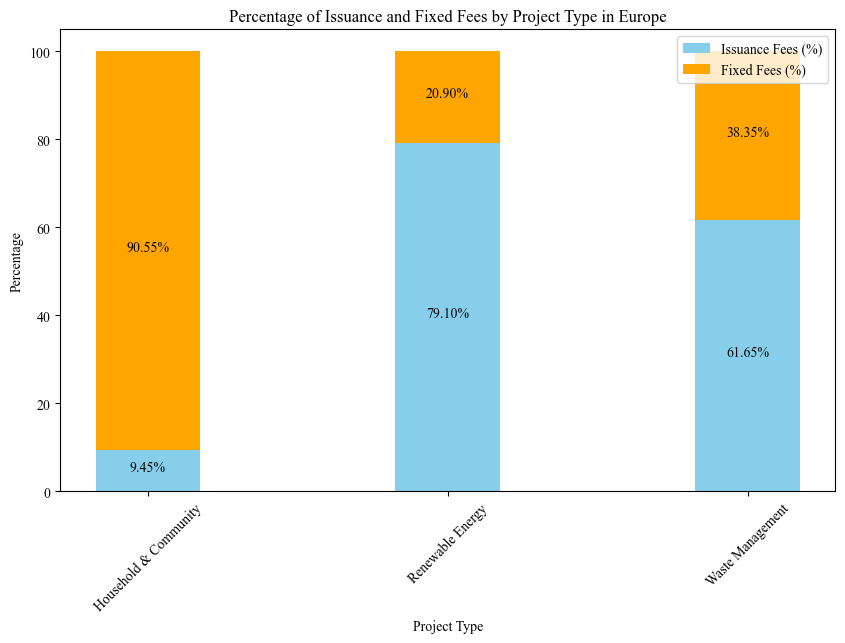

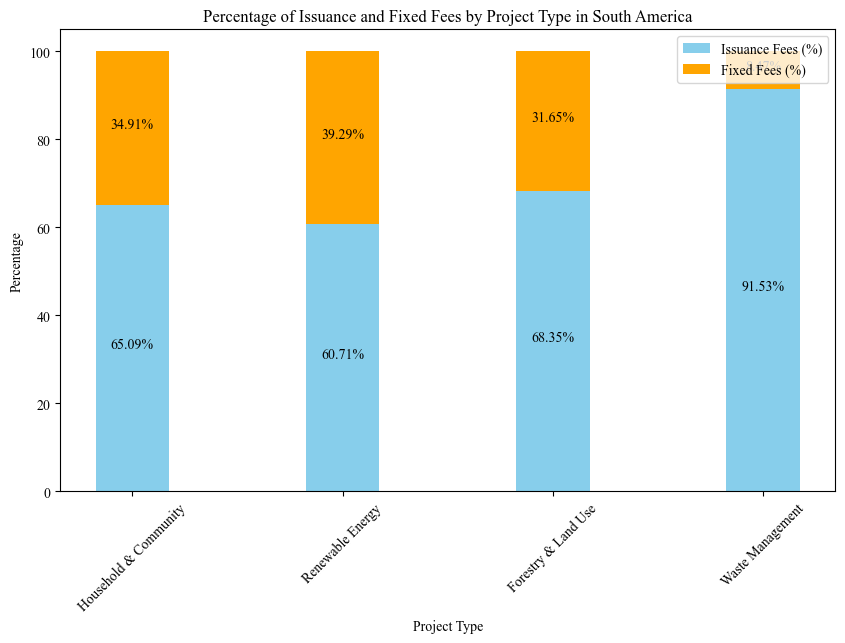

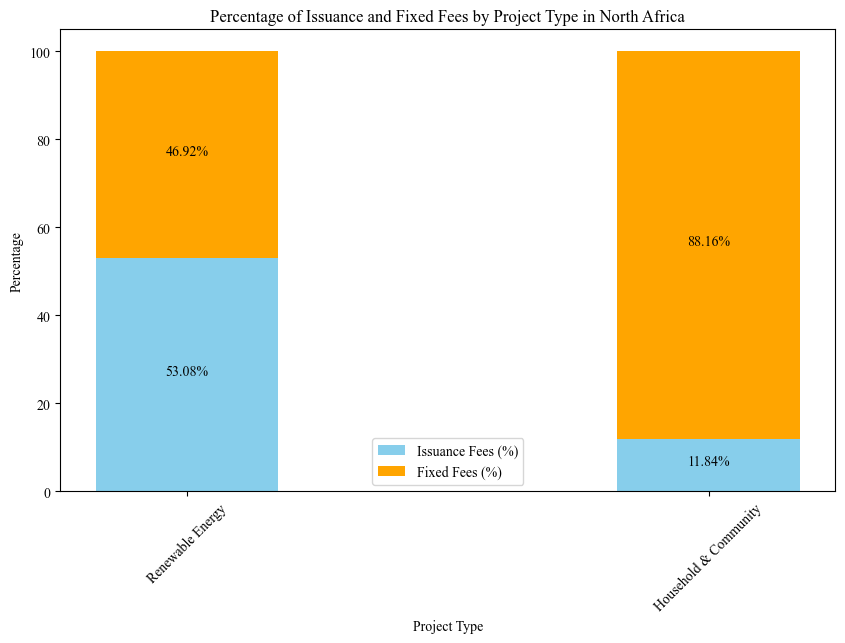

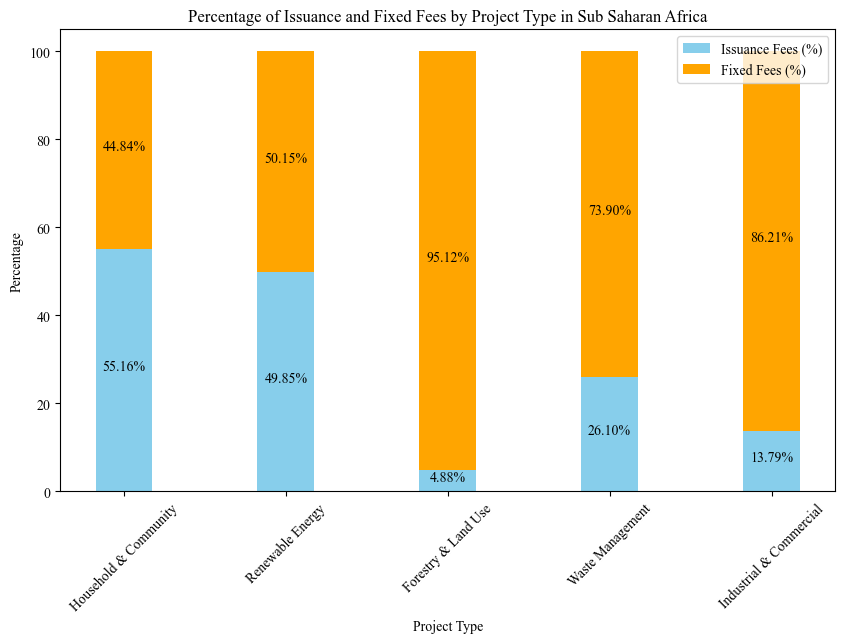

In [109]:
stats=data[data['Voluntary Registry']=='GOLD']     # Filtered completed projects dataset
# Filter data for each region
regions = stats['Region'].unique()
regions_of_interest = ['Europe', 'South America', 'North Africa', 'Sub Saharan Africa']
# Iterate through each region and create a grouped bar chart
for region in regions_of_interest:
    # Filter data for the current region
    region_data = stats[stats['Region'] == region]
    
    # Project types and average fees for the current region
    project_types = region_data['Scope'].unique()
    average_issuance_fees = region_data.groupby('Scope')['Total Issuance Fees'].mean()
    average_fixed_fees = region_data.groupby('Scope')['Total Fixed Fees'].mean()
    
    # Calculate the percentage of fixed fees and issuance fees for each project type
    total_fees = average_issuance_fees + average_fixed_fees
    issuance_fee_percentage = (average_issuance_fees / total_fees) * 100
    fixed_fee_percentage = (average_fixed_fees / total_fees) * 100
    
    # Set the bar width
    bar_width = 0.35
    
    # Create a grouped bar chart
    ind = np.arange(len(project_types))
    plt.figure(figsize=(10, 6))
    p1 = plt.bar(ind, issuance_fee_percentage, bar_width, label='Issuance Fees (%)', color='skyblue')
    p2 = plt.bar(ind, fixed_fee_percentage, bar_width, label='Fixed Fees (%)', bottom=issuance_fee_percentage, color='orange')
    
    plt.xlabel('Project Type')
    plt.ylabel('Percentage')
    plt.title(f'Percentage of Issuance and Fixed Fees by Project Type in {region}')
    plt.xticks(ind, project_types, rotation=45)
    plt.legend()
    
    # Add percentage labels on the bars
    for index, (issuance_percentage, fixed_percentage) in enumerate(zip(issuance_fee_percentage, fixed_fee_percentage)):
        plt.text(index, issuance_percentage/2, f'{issuance_percentage:.2f}%', ha='center', color='black')
        plt.text(index, issuance_percentage + fixed_percentage/2, f'{fixed_percentage:.2f}%', ha='center', color='black')
    
    plt.show()

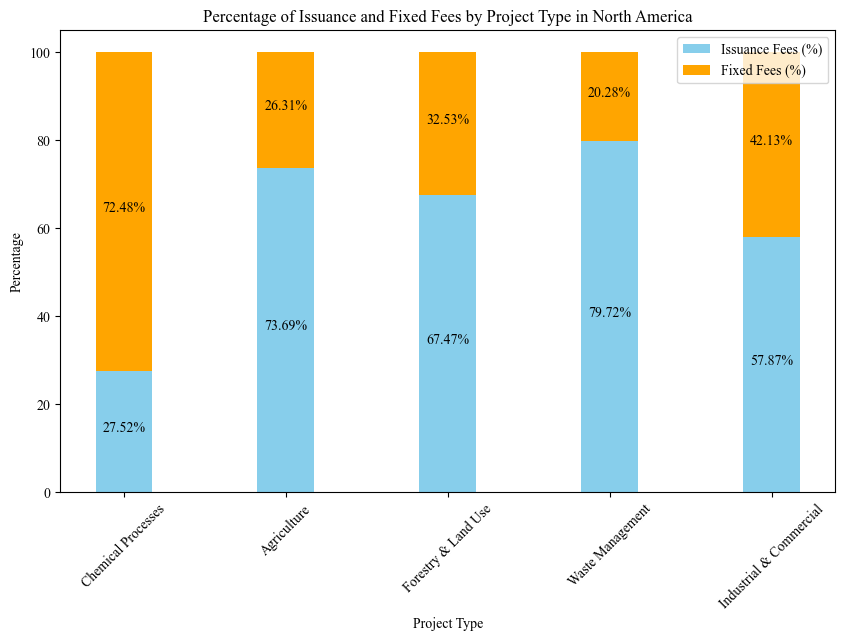

In [110]:
stats=data[data['Voluntary Registry']=='CAR']     # Filtered completed projects dataset
# Filter data for each region
regions = stats['Region'].unique()
regions_of_interest = ['North America']
# Iterate through each region and create a grouped bar chart
for region in regions_of_interest:
    # Filter data for the current region
    region_data = stats[stats['Region'] == region]
    
    # Project types and average fees for the current region
    project_types = region_data['Scope'].unique()
    average_issuance_fees = region_data.groupby('Scope')['Total Issuance Fees'].mean()
    average_fixed_fees = region_data.groupby('Scope')['Total Fixed Fees'].mean()
    
    # Calculate the percentage of fixed fees and issuance fees for each project type
    total_fees = average_issuance_fees + average_fixed_fees
    issuance_fee_percentage = (average_issuance_fees / total_fees) * 100
    fixed_fee_percentage = (average_fixed_fees / total_fees) * 100
    
    # Set the bar width
    bar_width = 0.35
    
    # Create a grouped bar chart
    ind = np.arange(len(project_types))
    plt.figure(figsize=(10, 6))
    p1 = plt.bar(ind, issuance_fee_percentage, bar_width, label='Issuance Fees (%)', color='skyblue')
    p2 = plt.bar(ind, fixed_fee_percentage, bar_width, label='Fixed Fees (%)', bottom=issuance_fee_percentage, color='orange')
    
    plt.xlabel('Project Type')
    plt.ylabel('Percentage')
    plt.title(f'Percentage of Issuance and Fixed Fees by Project Type in {region}')
    plt.xticks(ind, project_types, rotation=45)
    plt.legend()
    
    # Add percentage labels on the bars
    for index, (issuance_percentage, fixed_percentage) in enumerate(zip(issuance_fee_percentage, fixed_fee_percentage)):
        plt.text(index, issuance_percentage/2, f'{issuance_percentage:.2f}%', ha='center', color='black')
        plt.text(index, issuance_percentage + fixed_percentage/2, f'{fixed_percentage:.2f}%', ha='center', color='black')
    
    plt.show()

## Still to organize better

### Calculate unitary Cost

In [111]:
t = data.groupby(['Voluntary Registry'])[['unitary_cost']].median().reset_index()

### Fixed fees and variable fees

In [112]:
data['Fixed Fees Per Credit %'] = (data['Total Fixed Fees']/ data['Total Credits Issued']) / (data['Total Fees'] / data['Total Credits Issued'])

In [113]:
test = data.groupby(['Voluntary Registry'])[['Total Fixed Fees', 'Total Issuance Fees', 'Total Fees']].sum().reset_index()

In [114]:
test['percentage_of_fixed'] = (test['Total Fixed Fees']/ 1000000)/(test['Total Fees']/1000000) * 100
test['percentage_of_variable'] = (test['Total Issuance Fees']/ 1000000)/(test['Total Fees']/1000000) * 100

In [115]:
test

Voluntary Registry  Total Fixed Fees  Total Issuance Fees    Total Fees   
0                ACR      2.894390e+07         3.243228e+07  6.315178e+07  \
1                CAR      2.126852e+07         3.486402e+07  5.613254e+07   
2               GOLD      4.753871e+07         7.141425e+07  1.189530e+08   
3                VCS      3.003667e+07         2.317087e+08  2.617544e+08   

   percentage_of_fixed  percentage_of_variable  
0            45.832271               51.356078  
1            37.889825               62.110175  
2            39.964295               60.035705  
3            11.475134               88.521428

In [116]:
import pandas as pd

# Assuming you have a DataFrame named 'test2' with columns: 'Voluntary Registry', 'Transaction Year', 'Total Credits Issued', 'Total Issuance Fees', 'Total Fixed Fees', 'Total Fees'
test2 = data
# Sort the DataFrame by 'Voluntary Registry' and 'Transaction Year' in ascending order
test2 = test2.sort_values(by=['Voluntary Registry', 'First Year of Project'], ascending=[True, True])

# Create a flag for when the 'Voluntary Registry' changes
test2['Registry Change'] = (test2['Voluntary Registry'] != test2['Voluntary Registry'].shift()).astype(int)

# Calculate the cumulative sum of 'Total Credits Issued' per 'Voluntary Registry' with resets
test2['Cumulative Credits Issued'] = test2.groupby(['Voluntary Registry', 'Registry Change'])['Total Credits Issued'].cumsum()
test2['Cumulative Fixed Fees'] = test2.groupby(['Voluntary Registry', 'Registry Change'])['Total Fixed Fees'].cumsum()
test2['Cumulative Total Fees'] = test2.groupby(['Voluntary Registry', 'Registry Change'])['Total Fees'].cumsum()

# Drop the 'Registry Change' column if not needed
test2 = test2.drop(['Registry Change'], axis=1)

# Find the first time each registry's cumulative credits reach 1 million
first_time_1M = test2[test2['Cumulative Credits Issued'] >= 1000000]

# Keep only the first project for each registry that reached 1 million credits
first_time_1M = first_time_1M.drop_duplicates(subset='Voluntary Registry')

# Calculate the number of years it took for each registry to reach the first million credits
first_time_1M['Years to 1M'] = first_time_1M['First Year of Project'] - test2['First Year of Project'].min()

# Print the DataFrame with all the information
print(first_time_1M)


     Project ID                   Project Name Voluntary Registry ARB Project   
3828     ACR119              North Country LFG                ACR          No  \
599      CAR439  Bluesource - Camelot Landfill                CAR          No   
2651     GS2940             CO2OL Tropical Mix               GOLD          No   
1439     VCS233       Dortmund-Derne CHP Plant                VCS          No   

      First Year of Project  project_timeline   
3828                   1998                24  \
599                    2005                 8   
2651                   1996                26   
1439                   2001                 9   

                     Voluntary Status   
3828                        Completed  \
599                         Completed   
2651  Gold Standard Certified Project   
1439                       Registered   

                                 Project Developer  Total Credits Issued   
3828  Commonwealth Resource Management Corporation               1

In [117]:
first_time_1M

Project ID                   Project Name Voluntary Registry ARB Project   
3828     ACR119              North Country LFG                ACR          No  \
599      CAR439  Bluesource - Camelot Landfill                CAR          No   
2651     GS2940             CO2OL Tropical Mix               GOLD          No   
1439     VCS233       Dortmund-Derne CHP Plant                VCS          No   

      First Year of Project  project_timeline   
3828                   1998                24  \
599                    2005                 8   
2651                   1996                26   
1439                   2001                 9   

                     Voluntary Status   
3828                        Completed  \
599                         Completed   
2651  Gold Standard Certified Project   
1439                       Registered   

                                 Project Developer  Total Credits Issued   
3828  Commonwealth Resource Management Corporation               1592397  \
599                               Blue Source, LLC                471439   
2651                             ForestFinance GSF               2608807   
1439                                Carbon-TF B.V.                405158   

      Total Credits Retired  ...  Total Issuance Fees  Total Fees VVB Fees   
3828                1104920  ...            238859.55   357359.55  49000.0  \
599                  471439  ...             89573.41   126723.41  17500.0   
2651                1598637  ...            770642.10   862142.10      NaN   
1439                 399008  ...             81031.60    96531.60      NaN   

     unitary_cost percentage_of_fixed Fixed Fees Per Credit %   
3828     0.224416           33.159881                0.331599  \
599      0.268801           29.315815                0.293158   
2651     0.330474           10.613100                0.106131   
1439     0.238257           16.056918                0.160569   

     Cumulative Credits Issued Cumulative Fixed Fees Cumulative Total Fees   
3828                   1592397              118500.0             357359.55  \
599                    1406047              441500.0             721203.18   
2651                   2608807               91500.0             862142.10   
1439                   1251757               99000.0             349351.40   

     Years to 1M  
3828           2  
599            9  
2651           0  
1439           5  

[4 rows x 31 columns]

In [118]:
test = first_time_1M[['Voluntary Registry','Cumulative Fixed Fees', 'Cumulative Total Fees']]

In [119]:
test

Voluntary Registry  Cumulative Fixed Fees  Cumulative Total Fees
3828                ACR               118500.0              357359.55
599                 CAR               441500.0              721203.18
2651               GOLD                91500.0              862142.10
1439                VCS                99000.0              349351.40

In [120]:
test['percentage_of_fixed'] = test['Cumulative Fixed Fees']/ test['Cumulative Total Fees']

C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\2896534196.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['percentage_of_fixed'] = test['Cumulative Fixed Fees']/ test['Cumulative Total Fees']


In [121]:
test['percentage_of_fixed'] = test['percentage_of_fixed'] * 100

C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\4012980644.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['percentage_of_fixed'] = test['percentage_of_fixed'] * 100


In [122]:
test['percentage_of_variable'] = 100 - test['percentage_of_fixed']

C:\Users\Francisco Bentes\AppData\Local\Temp\ipykernel_26408\3195929909.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['percentage_of_variable'] = 100 - test['percentage_of_fixed']


In [123]:
test

Voluntary Registry  Cumulative Fixed Fees  Cumulative Total Fees   
3828                ACR               118500.0              357359.55  \
599                 CAR               441500.0              721203.18   
2651               GOLD                91500.0              862142.10   
1439                VCS                99000.0              349351.40   

      percentage_of_fixed  percentage_of_variable  
3828            33.159881               66.840119  
599             61.217145               38.782855  
2651            10.613100               89.386900  
1439            28.338229               71.661771

In [124]:
test = test.reset_index()

In [125]:
columns_to_drop = ['Cumulative Fixed Fees', 'Cumulative Total Fees', 'index']
test = test.drop(columns=columns_to_drop)

In [126]:
percentage_of_fees = test

In [127]:
percentage_of_fees

Voluntary Registry  percentage_of_fixed  percentage_of_variable
0                ACR            33.159881               66.840119
1                CAR            61.217145               38.782855
2               GOLD            10.613100               89.386900
3                VCS            28.338229               71.661771

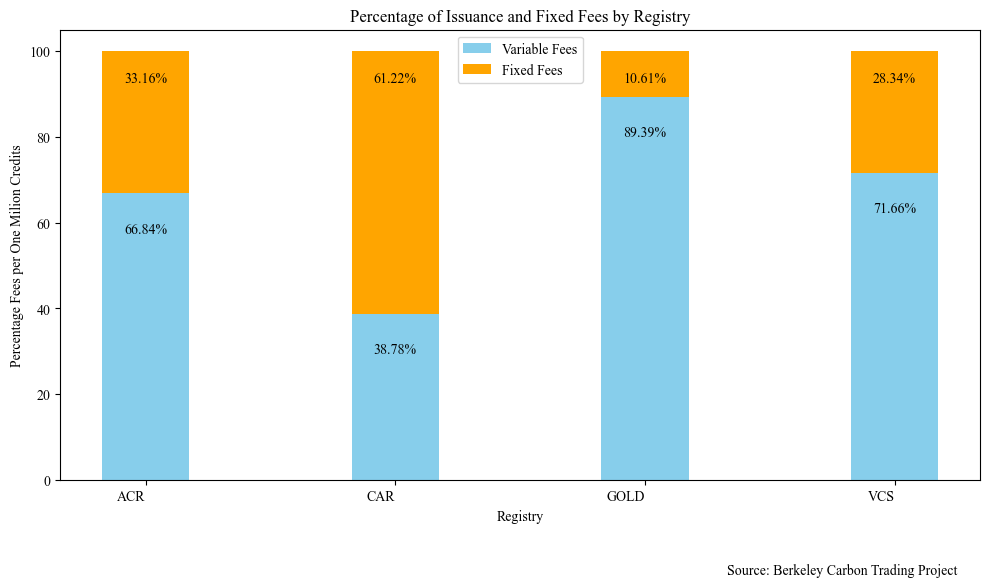

In [128]:
plt.figure(figsize=(10, 6))

# Number of bars (equal to the number of registries)
num_bars = len(percentage_of_fees['Voluntary Registry'])

# X-axis positions for the bars
ind = np.arange(num_bars)

# Width of each bar
bar_width = 0.35

# Create the grouped bar chart
plt.bar(ind, percentage_of_fees['percentage_of_variable'], bar_width, label='Variable Fees', color='skyblue')
plt.bar(ind, percentage_of_fees['percentage_of_fixed'], bar_width, label='Fixed Fees', bottom=percentage_of_fees['percentage_of_variable'], color='orange')

# Add numbers on top of each bar
for i in range(num_bars):
    plt.text(ind[i], percentage_of_fees['percentage_of_fixed'][i] + percentage_of_fees['percentage_of_variable'][i] - 8, f"{percentage_of_fees['percentage_of_fixed'][i]:.2f}%", ha='center', va='bottom', color='black')
    plt.text(ind[i], percentage_of_fees['percentage_of_variable'][i] - 10, f"{percentage_of_fees['percentage_of_variable'][i]:.2f}%", ha='center', va='bottom', color='black')

# Set the x-axis ticks and labels
plt.xticks(ind, percentage_of_fees['Voluntary Registry'])

plt.text(0.85, -0.2, 'Source: Berkeley Carbon Trading Project', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=10)

# Add a legend
plt.legend(loc='upper center')
# Add labels and a title
plt.xlabel('Registry')
plt.ylabel('Percentage Fees per One Milion Credits')
plt.title(f'Percentage of Issuance and Fixed Fees by Registry')

# Adjust layout to prevent x-axis labels from overlapping
plt.xticks(rotation=0, ha='right')
plt.tight_layout()

# Show the plot
plt.show()

In [129]:
data.to_csv('certifier_calculator.csv',index=False)

### Exploring when registring credits with gold or verra compensate - not completed

In [130]:
data

Project ID                                       Project Name   
0          VCS1  7.25 MW wind energy project of Aruppukottai Sr...  \
1        VCS100  Boiler fuel conversion from Furnace Oil to Bag...   
2        VCS101  Bagasse based Co-generation Power Project at K...   
3        VCS102  6 MW Rice Husk based cogeneration plant at Bha...   
4       VCS1021  Grid Connected Wind Power Project by M/s. D. J...   
...         ...                                                ...   
4177     ACR775                                          A-Gas V10   
4180     ACR805            HT HFC Reclamation Project Ontario 2021   
4185     ACR818          HT HFC Reclamation Project Champaign 2021   
4186     ACR819            HT HFC Reclamation Project Georgia 2021   
4189     ACR830                Advanced Refrigeration - ARS2021002   

     Voluntary Registry ARB Project  First Year of Project  project_timeline   
0                   VCS          No                   2006                 4  \
1                   VCS          No                   2005                 9   
2                   VCS          No                   2006                 4   
3                   VCS          No                   2008                 2   
4                   VCS          No                   2016                 7   
...                 ...         ...                    ...               ...   
4177                ACR          No                   2021                 1   
4180                ACR          No                   2021                 1   
4185                ACR          No                   2021                 1   
4186                ACR          No                   2021                 1   
4189                ACR          No                   2021                 1   

     Voluntary Status                                  Project Developer   
0          Registered                 Aruppukottai Sri Jayavilas Limited  \
1          Registered               JPMorgan Ventures Energy Corporation   
2          Registered  Triveni Engineering and Industries Limited (TEIL)   
3          Registered                          Bhageshwari Paper Pvt Ltd   
4          Registered                                  M/s D. J. Malpani   
...               ...                                                ...   
4177        Completed                                      A-Gas US Inc.   
4180        Completed                        Hudson Technologies Company   
4185        Completed                        Hudson Technologies Company   
4186       Registered                        Hudson Technologies Company   
4189        Completed                               Therm Solutions Inc.   

      Total Credits Issued  Total Credits Retired  ...        Country   
0                    21704                  21704  ...          India  \
1                    47015                  47015  ...          India   
2                    92353                  92353  ...          India   
3                    56282                  56282  ...          India   
4                    44652                  44652  ...          India   
...                    ...                    ...  ...            ...   
4177                343908                  21000  ...  United States   
4180                178538                      0  ...  United States   
4185               1259253                      0  ...  United States   
4186                292094                      0  ...  United States   
4189                 47025                  14521  ...  United States   

                                         Issuance Fees   
0                                     {'2009': 4340.8}  \
1     {'2009': 2206.8, '2010': 3745.8, '2013': 3450.4}   
2                         {'2009': 18470.600000000002}   
3                         {'2009': 11256.400000000001}   
4          {'2021': 6986.200000000001, '2022': 1944.2}   
...                                                ...   
4177   

In [131]:
def find_intersection(credits, costs_a, costs_b):
    intersection_points = []
    for i in range(len(credits) - 1):
        if costs_a[i] < costs_b[i] and costs_a[i + 1] > costs_b[i + 1] or costs_a[i] > costs_b[i] and costs_a[i + 1] < costs_b[i + 1]:
            intersection_points.append(credits[i])
    return intersection_points

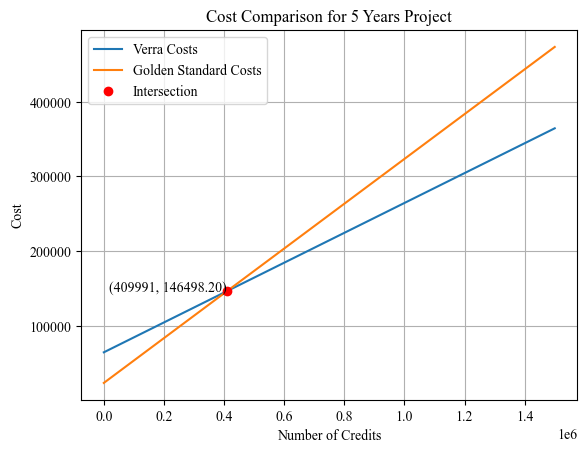

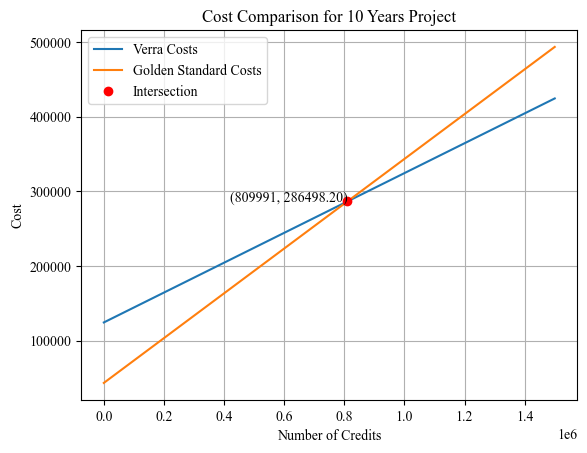

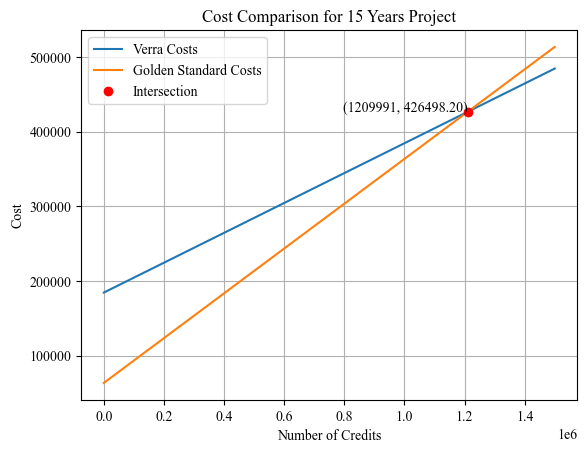

In [132]:
import matplotlib.pyplot as plt

calculator = VCSCertificationFeesCalculator()
calculator2 = GSCertificationFeesCalculator()
# Define functions to calculate costs
def calculate_costs(credits, fee, registry, years):
    if registry == 'VCS':
        first_year_fee = (calculator.account_opening_fee + calculator.pipeline_listing_request_fee+ calculator.project_registration_request_review_fee+ calculator.calculate_vvb_fee_application_approval()*years + calculator.calculate_account_maintenance_fee(1))  # Set the fixed fee for the first year
        regular_year_fee = (calculator.calculate_account_maintenance_fee(years) + 2*5000*years)  
        issue_costs =  [(credit * fee + first_year_fee + regular_year_fee) for credit in credits]# Set the regular fixed fee for subsequent years
        return issue_costs
    
    elif registry == 'GOLD':
        first_year_fee = ( calculator2.annual_registry_account_fee+ calculator2.calculate_vvb_fee_application_review())  # Set the fixed fee for the first year
        regular_year_fee = (calculator2.calculate_vvb_fee_application_renewal()*years + calculator2.calculate_vvb_fee_application_approval()*years + calculator2.annual_registry_account_fee * years) 
        issue_costs =  [credit * fee + first_year_fee + regular_year_fee for credit in credits]
         # Set the regular fixed fee for subsequent years
        return issue_costs

# Generate credit range from 1 to 10,000,000 with intervals of 10
credits_range = list(range(1, 1500001, 10))

# Define fees for Verra and Golden Standard
verra_fee = 0.2  # Replace this with the actual Verra fee
golden_standard_fee = 0.3  # Replace this with the actual Golden Standard fee

# Calculate costs for each credit range

# Plotting the graphs
years = [5, 10, 15]

for year in years:
    verra_costs = calculate_costs(credits_range, verra_fee, 'VCS', year)
    golden_standard_costs = calculate_costs(credits_range, golden_standard_fee, 'GOLD', year)
    plt.figure()
    plt.plot(credits_range, verra_costs, label='Verra Costs')
    plt.plot(credits_range, golden_standard_costs, label='Golden Standard Costs')
    intersection_points = find_intersection(credits_range, verra_costs, golden_standard_costs)
    
    intersection_found = False
    intersection_point = None
    
    for x, y in zip(credits_range, zip(verra_costs, golden_standard_costs)):
        if y[0] == y[1]:
            intersection_point = x
            intersection_found = True
            break  # Stop searching if an intersection is found

    if intersection_points:
        for intersection_point in intersection_points:
            plt.plot(intersection_point, verra_costs[credits_range.index(intersection_point)], 'ro', label='Intersection')
            # Print coordinates
            intersection_cost_verra = verra_costs[credits_range.index(intersection_point)]
            intersection_cost_golden = golden_standard_costs[credits_range.index(intersection_point)]
            plt.text(intersection_point, intersection_cost_verra, f'({intersection_point}, {intersection_cost_verra:.2f})', ha='right')
            
        plt.title(f'Cost Comparison for {year} Years Project - Intersection at {intersection_points} Credits')
    else:
        plt.title(f'Cost Comparison for {year} Years Project - No Intersection Found')
    plt.xlabel('Number of Credits')
    plt.ylabel('Cost')
    plt.title(f'Cost Comparison for {year} Years Project')
    plt.legend()
    plt.grid(True)
    plt.show()
